In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools
import random as random
import shutil

colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(list(mcolors.TABLEAU_COLORS)[:120])
markers_ls = ['o','s','v', '+', 'o', '*']
markers = itertools.cycle(markers_ls)

from scipy.special import psi
from scipy.special import polygamma
from scipy.special import erf, erfinv
from scipy.optimize import curve_fit

%matplotlib inline
mpl.style.use('classic')
mpl.style.use(['seaborn-whitegrid'])
from matplotlib.ticker import ScalarFormatter, NullFormatter
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams.update({'font.size': 16})

current_dir = os.getcwd() 
kPSep = os.sep

import struct
FLOAT_SIZE = 8

In [3]:
# function cause i am foking stupid
def crop_array(arr : np.array, av):
    i = 0
    moved = abs(arr - av)
    for i in range(len(arr)-1):
        if moved[i] < moved[i+1]:
            break
        i+=1
    return np.take(arr, np.arange(0, i+1))

arr = [-2, -1, 0, 1, 2]
av = np.mean(arr)
print(crop_array(arr, av))        


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()
     
def fit_one_over_v(x, a, c):
    return a/x + c

def fit_one_over_v2(x, a, b, c):
    return a/x + b/x/x + c

def two_to_minus_x(x, a, c):
    return a * np.power(2.0, -x) + c

[-2 -1  0]


# General pure states

We consider the system with $V$ modes dividing it on $V_A$ and $V_B$ subsystems such that $/mathcal{H}=\mathcal{H_A}\otimes\mathcal{H_B}$.
- $ f = V_A/V$
- $ d_A = 2 ^ {V_A}$
- $ d_B = 2 ^{V-V_A}$

We will the fraction number $f$ and with having the number of dimensions $D$ and fermionic nodes per site $N_{int}$

- $V=L^{D}N_{int}$
- $S_A(|\psi \rangle) = - \text{Tr}_{\mathcal{H_A}}\left[\hat{\rho}_A \ln \hat{\rho}_A \right] \quad \hat{\rho}_A = \text{Tr}_B |\psi\rangle\langle\psi|$ 



## Arbitrary number of particles

The average entanglement entropy of a uniformly distributed pure state in $\mathcal{H}$ restricted to subsystem A is given by the Page formula:
$$
    \langle S_A \rangle = 
    \left\{
    \begin{array}{lc}
        \Psi(d_Ad_B+1) - \Psi(d_B + 1) - \frac{d_A - 1}{2d_B}, & d_A\leq d_B \\
        \Psi(d_Ad_B+1) - \Psi(d_A + 1) - \frac{d_B - 1}{2d_A}, & \text{otherwise}
    \end{array}
    \right.,
$$

where $\Psi(x) = \Gamma ' (x) / \Gamma (x)$ is a digamma function.

Going to a thermodynamic limit, in big systems we can fix a fraction $f = V_A/V$ so what we get is:
$$
    \langle S_A \rangle = f V\ln 2 - 2 ^{-|1-2f|V-1} + O(2^{-V}),
$$
where we see the volueme law. For $f \neq \frac{1}{2}$, the second term is an exponentially small correction and becomes $-\delta _{f,1/2}$ as $V\rightarrow \infty$.

The variance is given for $d_A \leq d_B$:
$$
(\Delta S_A )^2 = \frac{d_A + d_B}{d_Ad_B + 1}\Psi ' (d_B + 1) - \Psi ' (d_Ad_B + 1) - \frac{(d_A - 1)(d_A + 2d_B - 1)}{4d_B^2(d_Ad_B + 1)},
$$
which again in the termodynamic limit becomes:
$$
(\Delta S_A )^2 = \left(\frac{1}{2}-\frac{1}{4}\delta_{f,1/2}\right)2^{-(1+|1-2f|)V}+o\left(2^{-(1+|1-2f|)V}\right).

# Function definitions

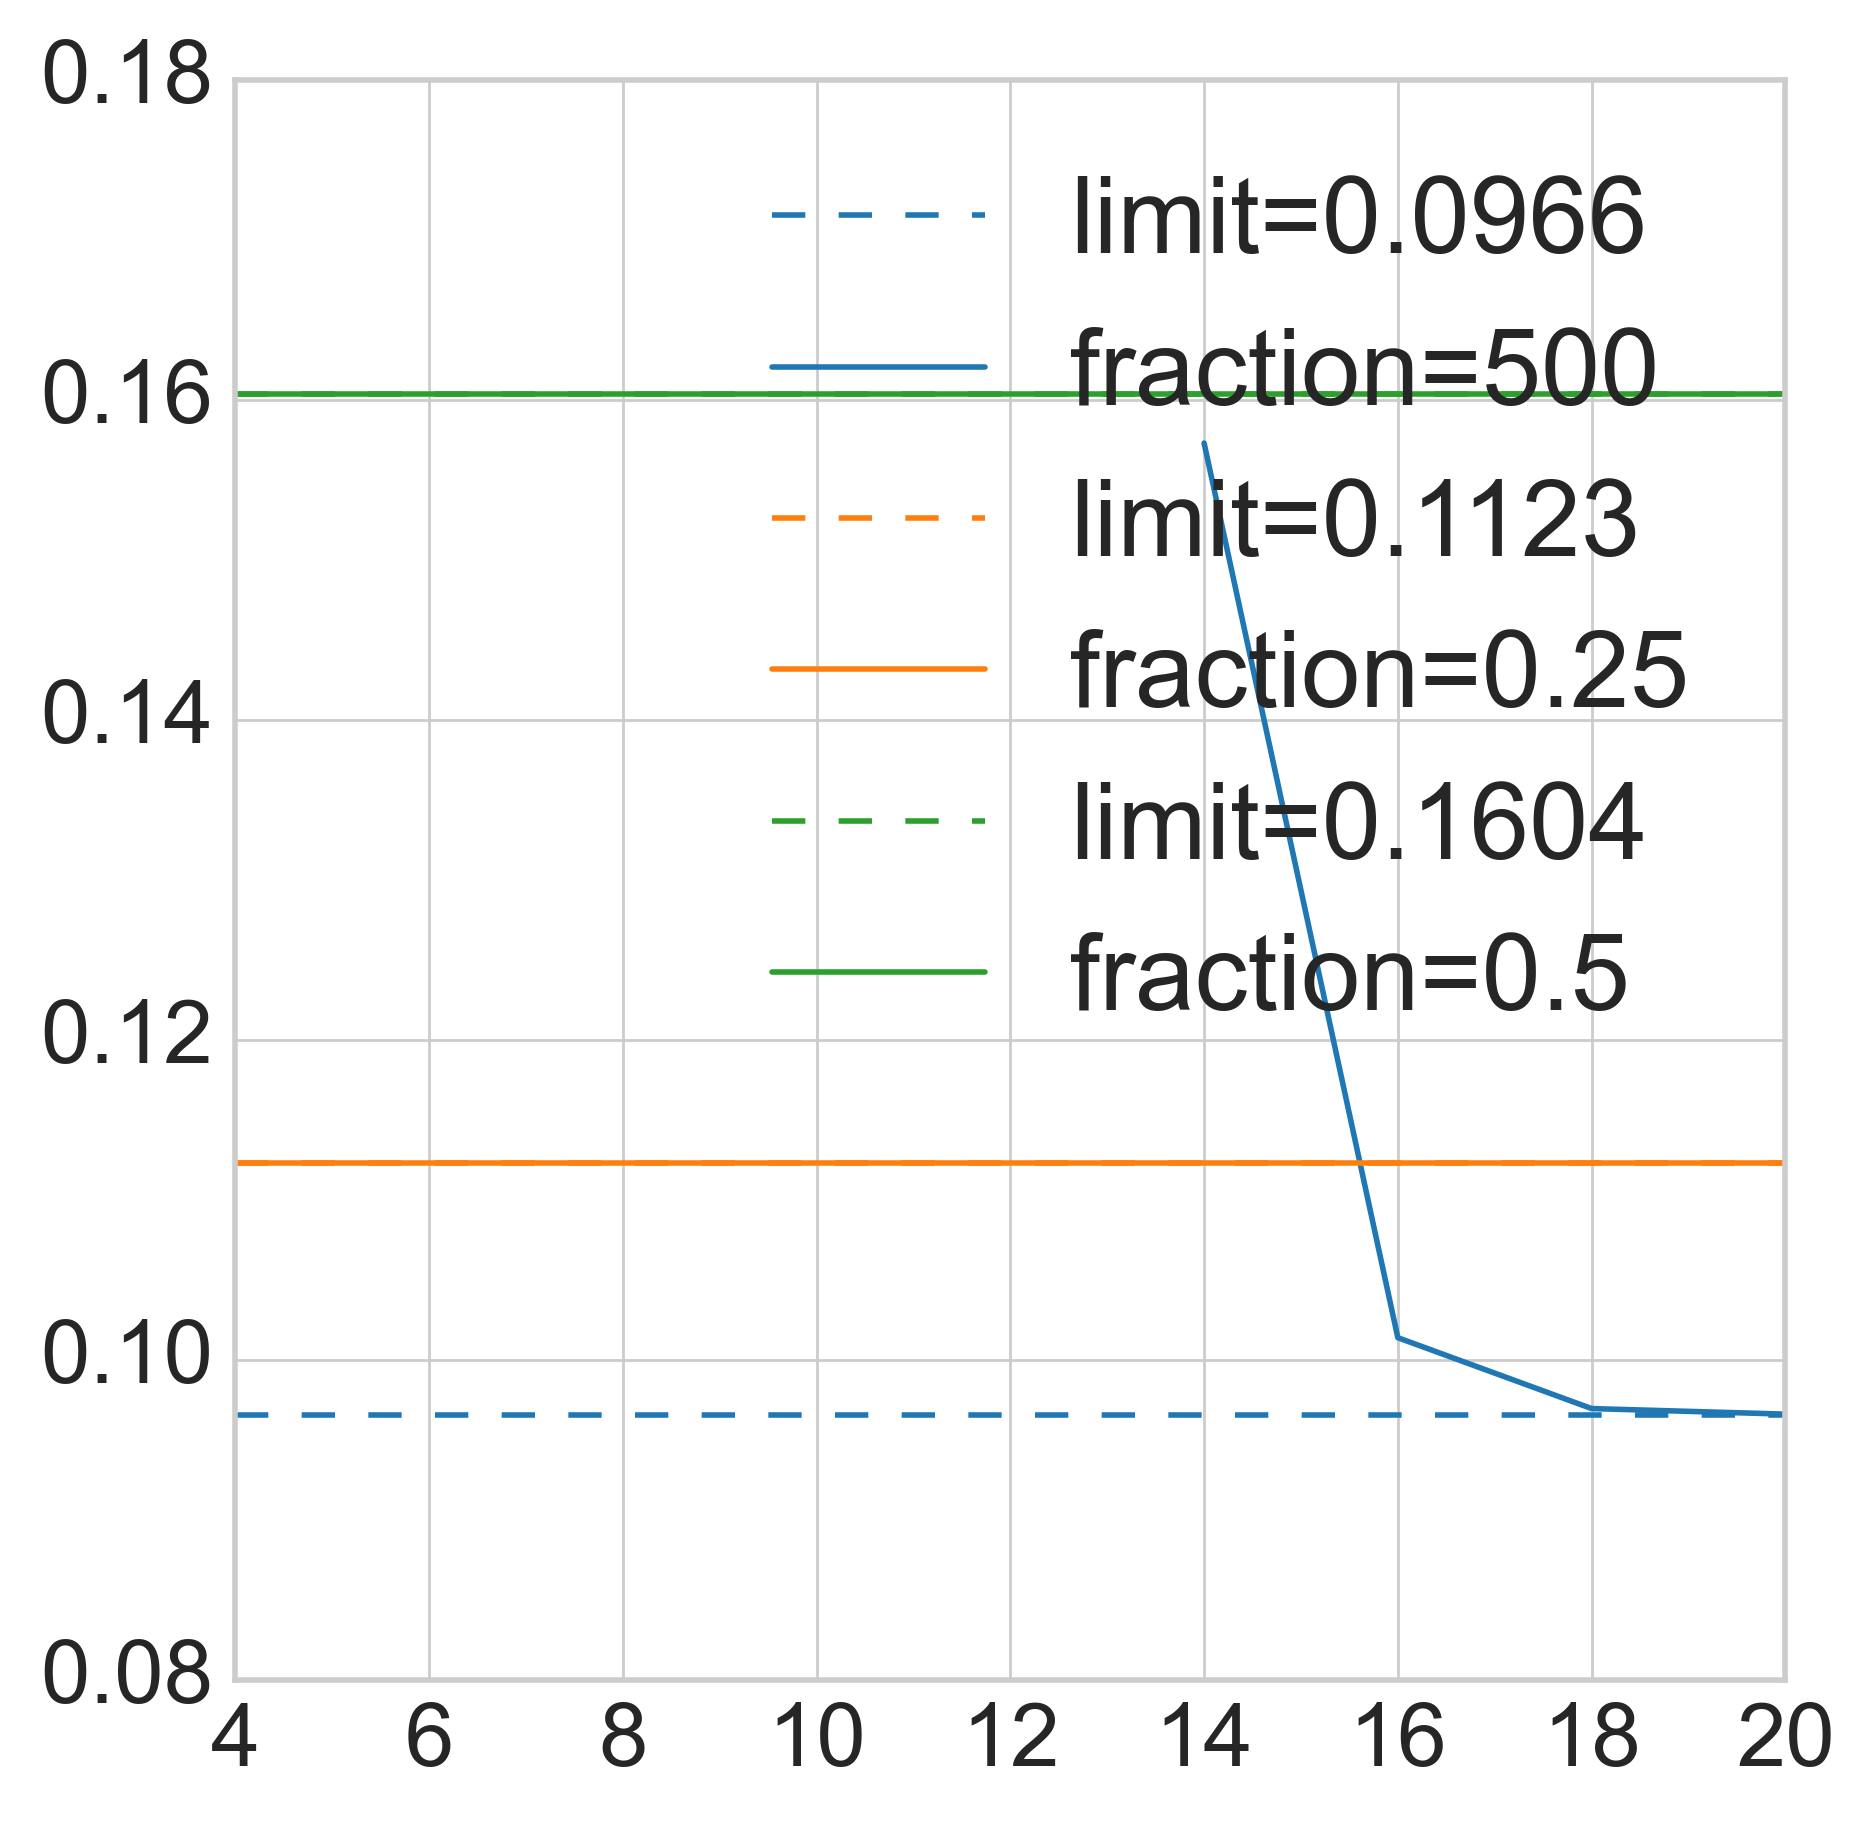

In [4]:
def page_result(d_a, d_b):
    if d_a <= d_b:
        return psi(d_a * d_b + 1) - psi(d_b + 1) - (d_a - 1)/(2*d_b)
    else:
        return psi(d_a * d_b + 1) - psi(d_a + 1) - (d_b - 1)/(2*d_a)

def page_result_var(d_a, d_b):
    return (((d_a + d_b)/(d_a*d_b + 1.0)) * polygamma(1, d_b + 1)) - polygamma(1, d_a*d_b + 1) - ((d_a-1)*(d_a + 2.0 * d_b - 1.0))/(4.0 * d_b * d_b * (d_a * d_b  + 1.0))

def page_thermodynamic(f, L, c = 1):
    return f * L * np.log(2.) - np.power(2., -np.abs(1-2*f)*L - 1) #+ 100 * np.power(2., -L)

def page_thermodynamic_var(f, L, c = 100):
    return (1/2 - 1/4 * (1.0 if f == 1/2 else 0.0)) * np.power(2., -(1+np.abs(1-2*f))*L) #+ 100*np.power(2., -(1.0+np.abs(1-2*f))*L)

def their_result(fraction_h, V):
    frac = fraction_h if fraction_h <= 1 else (V+2)*fraction_h/np.power(2.0, V)
    val = (V-1.0)*np.log(2)/2.0
    val += 2.0 * (np.exp(-np.power(erfinv(frac), 2.0)) - 1.0) / (frac * np.pi)
    return  val + (-2.0 + 2.0 * frac + np.exp(-np.power(erfinv(frac), 2.0)))*erfinv(frac)/(2.0*frac*np.sqrt(np.pi)) 

def page_their(la, L, c = 1.0):
    da = np.power(2.0, la)
    db = np.power(2.0, L-la)
    
    return np.log(da) - da / (2.0 * db) #+ c * 1.0/(da*db)

def plot_diff_page_their(L, frac, c = 1.0):
    fig, ax = plt.subplots(figsize=(5,5))
    for fr in frac:
        values = []
        for l in L:
            val = page_their(l//2, l) - their_result(fr, l)
            values.append(val)
        l = 1000
        color = next(colors_ls_cyc)
        limit = page_their(l//2, l, c) - their_result(fr, l)
        ax.axhline(y=limit, color=color, linestyle='--', label = f"limit={limit:.4f}")
        ax.plot(L, values, label=f'fraction={fr}', color=color)
    ax.legend()
    ax.set_ylim([0.08, 0.18])
    #ax.set_yscale('log')
    
c = 1e-5
plot_diff_page_their([i for i in range(4,22, 2)], [500, 1/4,0.5], c)

# Define the model

In [5]:
from math import ceil
from re import A


class ising_transverse:
    def __init__(self, Ns, J, J0, g, g0, h, w, sym = False, k = 0, p = 1, x = 1, bc = 0, index = 1.0):
        # if constant fraction means that we need to take care of how many do we take from given sector
        self.quiet = True
        # to set the indices
        self.index = 1.0
        
        self.mean_energy = 0.0
        self.average_idx_indices_col = {}
        self.N = 1
        self.Ns = 1
        self.N_full = 1
        self.all_symmetries = []
        self.real_symmetries = []
        self.imag_symmetries = []
        self.all_symmetries_str = []
        self.real_symmetries_str = []
        self.imag_symmetries_str = []
        self.bc = bc
        self.set_Ns(Ns)
        
        self.J = J
        self.J0 = J0
        self.g = g
        self.g0 = g0
        self.h = h
        self.w = w

        self.k = k
        self.p = p
        self.x = x
        self.sym = sym
        
    def set_Ns(self, Ns):
        self.Ns = Ns
        self.N = 1
        self.N_full = np.power(2, self.Ns)
        if self.bc == 0:
            self.all_symmetries = [(i, 1) for i in range(0, self.Ns)] + [(0, -1)] + ([(Ns//2, -1)] if self.Ns % 2 == 0 else [])
            self.real_symmetries = [(0, 1), (0, -1)] + ([(Ns//2, -1), (Ns//2, 1)] if self.Ns % 2 == 0 else [])
            self.all_symmetries_str = [str(i) for i in self.all_symmetries]
            self.real_symmetries_str = [str(i) for i in self.real_symmetries]
        else:
            self.all_symmetries = [(0, 1), (0, -1)]
            self.real_symmetries = [(0, 1), (0, -1)]
            self.all_symmetries_str = [str(i) for i in self.all_symmetries]
            self.real_symmetries_str = [str(i) for i in self.real_symmetries]
        self.imag_symmetries = list(set(self.all_symmetries).difference(self.real_symmetries))
        self.imag_symmetries_str = [str(i) for i in self.imag_symmetries] 
        
    def set_hilbert_space(self, energies):
        self.N = len(energies)
               
    def get_info(self):
        if not self.sym:
            return f"Ns={self.Ns},J={self.J:.2f},J0={self.J0:.2f},g={self.g:.2f},g0={self.g0:.2f},h={self.h:.2f},w={self.w:.2f},bc={self.bc}"
        else:
            return f"Ns={self.Ns},J={self.J:.2f},g={self.g:.2f},h={self.h:.2f},k={self.k:.2f},p={self.p},x={self.x},bc={self.bc}"
        
    def get_info_wo_sym(self):
        if not self.sym:
            return self.get_info()
        else:
            return f"Ns={self.Ns},J={self.J:.2f},g={self.g:.2f},h={self.h:.2f},bc={self.bc}"
    
    def get_dir(self, dir = "resultsSym"):
        directory = dir + str(self.Ns) + kPSep
        if self.sym:
            return directory + f"_ising_sym," + self.get_info() + kPSep
        else:
            return directory + f"_ising," + self.get_info() + kPSep
    
    def set_mean_energy(self, dir):
        k_start = self.k
        p_start = self.p

        all_energies = None
    
        for i in self.all_symmetries:
            self.k = i[0]
            self.p = i[1]
            en, N = self.get_energy_file(dir)
            if en.empty:
                continue
            if all_energies is None:
                all_energies = en.copy()
            else:
                all_energies.append(en, ignore_index = True)
        if all_energies is None:
            return
        # find the index of the nearest mean
        mean = all_energies['energy'].mean(axis=0)
        if not self.quiet : print(f'-->mean_energy{mean}')
        self.mean_energy = mean
        for i in self.all_symmetries:
            self.k = i[0]
            self.p = i[1]
            en, N = self.get_energy_file(dir)
            if en.empty:
                continue
            if not self.quiet : print(f'for symmetry {i}, N={N}')
            # how many columns do we have for given sector
            num_cols = self.index * N
            if not self.quiet : print(f'\t->* (index={self.index}) -> {num_cols}')
            
            en_np = np.array(en['energy'])
            mean_sec = np.mean(en_np)
            # find the mean of this sector
            
            # find the nearest idx to energy mean
            nearest_idx = find_nearest_idx(en_np, mean)
            nearest_en = find_nearest(en_np, mean)
            if not self.quiet : print(f'\t->total mean_index={nearest_idx},en_mean at that idx={nearest_idx}:{nearest_en}')  
            
            # find the new corresponding index
            bounds = None
            
            #crop this foking thing
            middle_sec = find_nearest_idx(en_np, mean_sec)
            if not self.quiet : print(f'\t->this mean_index={middle_sec} and its energy = {en_np[middle_sec]}')
            
            if(middle_sec - num_cols//2 < 0) or (middle_sec + num_cols//2) >= N:
                if not self.quiet : print(f'\t\t->this index is not enough for those number of states')
                bounds = (N//2 - num_cols//2, N//2 - num_cols//2 + num_cols)
            else:
                bounds = (middle_sec - num_cols//2, middle_sec - num_cols//2 + num_cols)
                if not self.quiet : print(f'\t\t->bounds:{bounds}')

            if self.index == 1.0:
                if not self.quiet : print("\t\t->this whole energy is already the index")
                en_crop = en_np
                to_save = nearest_idx
            else:
                en_crop = en_np[int(bounds[0]):int(bounds[1])]
                to_save = find_nearest_idx(en_crop, nearest_en)
                if not self.quiet : print(f'\t->new (total mean index) (after taking bounds)={to_save} and its energy = {en_crop[to_save]}')
                
            self.average_idx_indices_col[(self.k, self.p)] = to_save
            #print(self.average_idx_indices_col[(self.k, self.p)], N, middle_sec)
        
        self.k = k_start
        self.p = p_start
        return self.average_idx_indices_col

    def read_entropies_binary(self, dir):
        directory = self.get_dir(dir)
        if not os.path.exists(directory):
            return pd.DataFrame(), 1.0

        tmp = None
        frac = 1.0
        files = os.listdir(directory)
        tmp = "entropies,spectrum_num=" + f"{int(self.N)}.bin"
        if tmp not in files or frac > self.N:
            tmp = None
        if tmp is not None:
            size_x = (self.Ns//2)
            #values = []
            values = np.zeros(size_x * self.N)
            index = np.arange(1, self.Ns // 2 + 1)
            columns = [i for i in range(1, self.N+1)]
            
            with open(directory + tmp, mode='rb') as file: # b is important -> binary
                idx = 0
                while file:
                    binary = file.read(FLOAT_SIZE)
                    if not binary:
                        break    
                    val = struct.unpack("d", binary)[0]
                    values[idx] = val
                    idx += 1
            values = values.reshape(self.N, size_x)
            df = pd.DataFrame(index, columns = [0])
            values = np.matrix.transpose(np.array(values))
            df = pd.concat([df, pd.DataFrame(values, columns=columns)], axis=1)
            return df, 1.0
        else:
            return pd.DataFrame(), 1.0
    
    def check_files(self, fraction, dir, name, columns):
        directory = self.get_dir(dir)
        
        tmp = None
        frac = fraction
        if not os.path.exists(directory):
            return pd.DataFrame(), frac
        
        files = os.listdir(directory)
        if frac > 1.0:
            tmp = name + f"{int(frac)}.dat"
            if tmp not in files or frac > self.N:
                tmp = None
        else:
            tmp = None
            for file in files:
                if f"{frac:.2f}x" in file and file.startswith(name):
                    tmp = file
                    frac = round(fraction * self.N)
                    break        
                
        if tmp is not None:
            if columns is not None:
                df = pd.read_csv(directory + tmp, names = columns, sep="\t")
                return df, frac
            else:
                df = pd.read_csv(directory + tmp, sep="\t", header=None,)
                if len(df) == self.Ns//2:
                    return df, frac
        return pd.DataFrame(), frac
    
    def get_values_num(self, fraction, cols_to_take):
        bad = False
        values_num = round(fraction * self.N) if fraction <= 1.0 else int(fraction)
        if not self.quiet : print(f'N={self.N},fraction={fraction},values_num={values_num}')
        
        # if it is the same as index dataframe fraction
        if fraction == self.index:
            return bad, self.average_idx_indices_col[(self.k, self.p)], 0, np.round(self.index * self.N)
        
        if values_num > len(cols_to_take) or (fraction <= 1.0 and fraction > self.index):
            print(f"Too much for {self.get_info()} model")
            bad = True
            
        # how much there is
        av_idx = self.average_idx_indices_col[(self.k, self.p)]
        if not self.quiet : print(f'av_idx = {av_idx}')
        #av_idx = len(cols_to_take)//2
        # bounds - take all around those
        
        lower = av_idx - (values_num // 2)
        if lower < 0:
            print("bad lower bound for : " + self.get_info())
            bad = True
            
        upper = av_idx + (values_num // 2)
        if upper >= len(cols_to_take):
            print("bad upper bound for : " + self.get_info())
            bad = True
        
        if bad and values_num <= self.N:
            return False, values_num//2, 0, values_num-1
        else:
            return bad, av_idx, lower, upper

    def get_symmetries(self, sectors = 'all'):
        if sectors == 'all':
            return self.all_symmetries
        elif sectors == 'real':
            return self.real_symmetries
        elif sectors == 'imaginary':
            return self.imag_symmetries
        else:
            return [(self.k, self.p)]
        
    # ------------------------------- creating file with averages --------------------------------
    '''
    Creates files with given averages assuming that there exists one file from to_check
    '''
    def create_averages_files(self, fractions, dir_create, dir = "{kPSep}resultsSym", copy = False):
        en, _ = self.get_energy_file(dir)
        #self.set_mean(dir)
        if en.empty:
            print("\t" + self.get_info(), "\t->empty energy dataframe : " + dir + '->energy.dat')
            return
        # check for half of the spectrum first
        df, frac = self.get_entropies_file(self.index, dir)
        if df.empty:
            print("\t" + self.get_info(), "\t->empty dataframe : " + dir + '->entropies')
            return
        columns = df.columns
        # create a new directory
        directory = self.get_dir(dir_create)
        try: 
            os.makedirs(directory) 
        except OSError as error: 
            if not self.quiet : print(error)
        if not os.path.exists(directory + 'energies.dat'):
            en.to_csv(directory + 'energies.dat', sep = '\t', header=False)
        
        # iterate through fractions
        for fraction in fractions:
            cols_to_take = columns[1:]

            # index fraction states number
            states_num = len(cols_to_take)

            bad, av_idx, lower, upper = self.get_values_num(fraction, cols_to_take)
            if not self.quiet : print(f'\t->get_values_num() returned {bad, av_idx, lower, upper}')
            if bad:
                print("\t\t\t->breaking :" + str(fraction))
                continue       
            # take a new directory
            directory = self.get_dir(dir_create)
            name = "spectrum_num=" + (f"{fraction:.2f}x{self.N}={upper - lower}" if fraction <= 1.0 else f"{int(fraction)}")
            name_av = directory + 'av_entropies,' + name + '.dat'
            name_var = directory + 'var_entropies,' + name + '.dat'
            name_all = directory + 'entropies,' + name + '.dat'
            #if os.path.exists(name_av) and os.path.exists(name_var):
            #    break
            if fraction == self.index and copy:
                filename = f'entropies,spectrum_num={self.N}.bin'
                shutil.copyfile(f'{self.get_dir(dir)}{filename}', f'{directory}{filename}')
                if not self.quiet : print(f'copied from {self.get_dir(dir)}{filename} to {directory}{filename}')
                continue
            
            # check if we are not outside our fraction
            if int(fraction * self.N) <= frac or (fraction > 1 and fraction <= frac):                
                cols_to_take = list(cols_to_take)[lower : upper]
                print(len(cols_to_take))
                if not self.quiet : print('cols_to_take', cols_to_take)
                
                df_tmp = df.loc[:,[columns[0]] + cols_to_take]
                df_tmp['var_S'] = df_tmp.loc[:,cols_to_take].var(axis=1)
                df_tmp['av_S'] = df_tmp.loc[:,cols_to_take].mean(axis=1)
                
                index = [i for i in range(1, self.Ns//2 + 1)]
                df_tmp.index = index
                
                df_tmp[['var_S', 'av_S']].to_csv(name_var, sep = '\t', header=False)
                df_tmp[['av_S', 'var_S']].to_csv(name_av, sep = '\t', header=False)

                # save whole
                df_tmp.loc[:, cols_to_take].to_csv(name_all, sep = '\t', header=False)   
                
                print(f'for {self.get_info()} created v={fraction}')
    '''
    Creates files with given averages assuming that there exists one file from to_check - all symmetry sectors
    '''           
    def create_averages_all_sectors(self, fractions, dir_create, dir = "{kPSep}resultsSym", copy = False):
        k_start = self.k
        p_start = self.p
        
        self.set_mean_energy(dir)
        
        for i in self.all_symmetries:
            self.k = i[0]
            self.p = i[1]
            self.create_averages_files(fractions, dir_create, dir, copy)
        
        self.k = k_start
        self.p = p_start
    
    # ------------------------------- getting file with averages --------------------------------
    ''' 
    Gets the file with averages over different subsystem sizes
    '''         
    def get_averages_file(self, fraction, dir = "{kPSep}resultsSym"):
        en, _ = self.get_energy_file(dir)
        
        df, frac = self.check_files(
            fraction, 
            dir,
            "av_entropies,spectrum_num=",
            columns = ["L_a", "av_S", "empty"]
            )
        
        if len(df) == 0:
            return pd.DataFrame(), 1
        
        df['L_a'] = df['L_a'] / self.Ns
        return df.drop(["empty"], axis=1), frac
    
    # ------------------------------- getting variance of entropies together --------------------------------

    '''
    Returns the dataframe with the variance
    '''     
    def get_variance(self, fraction, dir = "{kPSep}resultsSym"):
        self.get_energy_file(dir)
        # check if such file is saved already
        df, frac = self.check_files(
            fraction, 
            dir,
            "var_entropies,spectrum_num=",
            columns = ["L_a", "var", "empty"]
            )
        if len(df) == 0:
            df, frac = self.get_entropies_file(fraction, dir)
        else:
            df['L_a'] = df['L_a'] / self.Ns
            return df.drop(["empty"], axis=1), frac          
          
        # if it fails again    
        if len(df) == 0:
            return pd.DataFrame(), 1
        
        col = (df[df.columns[1:]].var(axis = 1))
        df['var'] = col
        return df[['L_a', 'var']], frac
     
    # ------------------------------- getting energiesssssssss --------------------------------

    '''
    Gets the energy file
    '''
    def get_energy_file(self, dir = "{kPSep}resultsSym"):
        df = None
        
        directory = self.get_dir(dir)
        if not os.path.exists(directory):
            #print(directory, "doesn't exists")
            return pd.DataFrame(), 1
        tmp = "s"
        tmp.startswith
        files = os.listdir(directory)
        for file in files:
            if file.startswith('energies'):
                df = pd.read_csv(directory + file, names = ["energy"], sep="\t")
                save = False
                if str(df['energy'].iloc[0]).startswith('this'):
                    values = [float(str(i).split('=')[-1]) for i in list(df['energy'])]
                    df['energy'] = values
                    save = True
                #print(df)
                if len(df) != 0:
                    if save:
                        df.to_csv(directory + file, sep = "\t", header=False)
                    break            
 
        if len(df) == 0:
            self.N = 0
            return pd.DataFrame(), 1
        
        self.set_hilbert_space(df)
        return df, self.N
    
    # ------------------------------- getting all entropies together --------------------------------
    '''
    Gets the file with different entropies
    '''
    def get_entropies_file(self, fraction, dir = "{kPSep}resultsSym"):
        
        en = self.get_energy_file(dir)
        
        # extract other fractions from the bigger ones
        df, frac = self.read_entropies_binary(dir)

        # how many values do we take
        values_num = round(fraction * self.N) if fraction <= 1.0 else int(fraction)
        if len(df) == 0 or values_num > (frac * self.N):
            self.N = 0
            if not self.quiet: print("\t\tbaaad\t" + self.get_info())
            return pd.DataFrame(), 1.0
        
        df.rename(columns={0: "L_a"}, inplace = True)
        df['L_a'] = df['L_a'] / self.Ns
        columns = df.columns

        if fraction == 1.0:
            # if it is already the file that we wanted
            if not self.quiet: print("\t->reading already saved")
            return df, len(df.columns[1:])
        else:
            cols_to_take = columns[1:]
            bad, av_idx, lower, upper = self.get_values_num(fraction, cols_to_take)
            if not self.quiet : print(f'\t->get_values_num() returned {bad, av_idx, lower, upper}')

            cols_to_take = cols_to_take[lower : upper]
            cols_to_take = [columns[0]] + list(cols_to_take)
                   
            return df[cols_to_take], values_num
    
    '''
    Concatenates all entropies from different sectors that we want together
    '''
    def concat_entropies(self, fraction, dir = "{kPSep}resultsSym", sector = 'all'):
        df = pd.DataFrame(columns = ['sector'] + [i/self.Ns for i in range(1, self.Ns//2 + 1)])        
        syms = self.get_symmetries(sector)
        N = 0
        k = self.k
        p = self.p
        for i in syms:
            self.k = i[0]
            self.p = i[1]
            df_tmp, frac = self.get_entropies_file(fraction, dir)
            # append to check
            #N += int(frac * self.N) if frac <= 1.0 else frac
            df_tmp2 = pd.DataFrame()
            for index, row in df_tmp.iterrows():
                L_a = row['L_a']
                values = row[df_tmp.columns[1:]]
                df_tmp2[L_a] = np.array(values)
                
            df_tmp2['sector'] = [(self.k,self.p) for i in range(len(df_tmp2))]
            # append to the dataframe
            df = df.append(df_tmp2, ignore_index = True)
            
        self.k = k
        self.p = p
        
        print(self.get_info() + "\n\t->" + f"N={len(df)}")
        return df
    
    # ------------------------------- getting different symmetry sectors entropies together --------------------------------

    '''
    Returns the dataframe with averages in each symmetry sectors
    '''
    def symmetry_sectors(self, fraction, dir = "{kPSep}resultsSym", var = False, sector = 'all'):
        df = pd.DataFrame()
        df['L_a'] = np.array([i for i in range(1, self.Ns//2 + 1)]) / self.Ns
        
        col_name = 'av_S' if not var else 'var'
        #self.create_averages_all_sectors([fraction], dir)
        name = 'av_S' if not var else 'var'
        N_all = 0
        k = self.k
        p = self.p
        for i in self.all_symmetries:
            self.k = i[0]
            self.p = i[1]
            
            # exclude imaginary symmetries
            if sector == 'real' and i not in self.real_symmetries:
                continue
            # exclude real symmetries
            if sector == 'imaginary' and i in self.real_symmetries:
                continue
            
            df_tmp, frac = self.get_averages_file(fraction, dir) if not var else self.get_variance(fraction, dir)
            if df_tmp.empty:
                df_tmp, frac = self.get_entropies_file(fraction, dir)
                df_tmp[name] = df_tmp.loc[:, df_tmp.columns[1:]].mean(axis=1) if not var else df_tmp.loc[:, df_tmp.columns[1:]].var(axis=1)
                df_tmp = df_tmp.loc[:, [df_tmp.columns[0], name]]
            
            if len(df_tmp) != 0:
                df[str(i) + f':{self.N}'] = np.array(df_tmp.loc[:, col_name])
            else:
                print(f"->For {self.Ns} missing {'variance ' if var else ''}{i},frac={fraction},bc={self.bc}")
            N_all += self.N
            
        if (self.bc==0 and not sector == 'all') or (self.bc == 1):
            print(f"\t->{('Did' if (self.N_full==N_all) else 'Didnt')} capture whole Hilbert space - for Ns = {self.Ns}, bc = {self.bc}, frac = {fraction}")
        
        self.k = k
        self.p = p   
        return df
    
    '''
    Gets all different symmetry sectors mean from all entropies file
    '''
    def get_all_symmetry_sectors(self, fraction, dir = "{kPSep}resultsSym", var = False):

        df, frac = pd.DataFrame(), 1
        df['L_a'] = np.array([i for i in range(1, self.Ns//2 + 1)]) / self.Ns
        
        
        k = self.k
        p = self.p
        col_name = 'av_S' if not var else "var"
        N_all = 0
        for i in self.all_symmetries:
            self.k = i[0]
            self.p = i[1]
            # check if the averages file exists already
            df_tmp, frac = self.get_averages_file(fraction, dir) if not var else self.get_variance(fraction, dir)

            if not df_tmp.empty:
                df[str(i) + f':{self.N}:{frac}'] = np.array(df_tmp.loc[:,col_name])
                print(f"-->For {self.Ns},sym={i},frac={fraction},bc={self.bc} reading the {col_name} file")
                
            # else take entropies
            else:
                df_tmp, values_num = self.get_entropies_file(fraction, dir)
                print(f"-->For {self.Ns},sym={i},frac={fraction},bc={self.bc} reading the whole entropies file binary")
                if not df_tmp.empty:
                    if var:
                        df_tmp[col_name] = df_tmp.loc[:,df_tmp.columns[1:]].var(axis=1)
                    else:
                        df_tmp[col_name] = df_tmp.loc[:,df_tmp.columns[1:]].mean(axis=1)           
                    df[str(i) + f':{self.N}:{len(df_tmp.columns[1:-1])}'] = np.array(df_tmp.loc[:,col_name])
                else:
                    print(f"->For {self.Ns} missing {i},frac={fraction},bc={self.bc}")
            N_all += self.N
        
        
        self.k = k
        self.p = p    
        print(f"\t->{('Did' if (self.N_full==N_all) else 'Didnt')} capture whole Hilbert space - for Ns = {self.Ns}, bc = {self.bc}, frac = {fraction}")
        return df
    
    '''
    Averages over specific symmetry sectors
    '''
    def average_symmetry_sectors(self, fraction, dir = "{kPSep}resultsSym", sector = 'all', var = False):
        df = self.symmetry_sectors(fraction, dir, var, sector)
        col_name = 'av_S' if not var else 'var'
        df[col_name] = [0.0 for i in range(len(df))]
    
        columns = df.columns
        columns = columns[1:-1]
        
        norm = 0
        for col in columns:
            N_tmp = int(col.split(':')[1])
            sym = col.split(':')[0]
            if sector == 'real' and (sym not in self.real_symmetries_str):
                continue
            if sector == 'imaginary' and (sym in self.real_symmetries_str):
                continue
            
            df.loc[:,col_name] += N_tmp * df.loc[:,col]
            norm += N_tmp
            
        df[col_name] /= norm
        return df.loc[:,['L_a', col_name]], 1
    
    '''
    Averages over specific symmetry sectors in one dataframe
    '''
    def average_symmetry_sectors_df(self, df : pd.DataFrame):
        av_real = 'av_Sr'
        N_r = 0
        N_r_total = 0
        av_other = 'av_So'
        N_o = 0
        N_o_total = 0
        av_together = 'av_S'
        N_t = 0
        N_total = 0
        
        df_tmp = pd.DataFrame(columns=[av_real, av_other, av_together])
        df_tmp.loc[0] = [0.,0.,0.]
        for col in df.columns:
            N_tmp = int(col.split(':')[-2])
            sym = col.split(':')[0]
            N_tmp_total = int(col.split(':')[-1])
            if sym in self.real_symmetries_str:
                #print('real:')
                #print('\t', sym)
                N_r_total += N_tmp_total
                N_r += N_tmp
                
                #df_tmp.loc[:,av_real] += N_tmp_total * np.array(df.loc[:,col])
                df_tmp.loc[:,av_real] += N_tmp * np.array(df.loc[:,col])
                #df_tmp.loc[:,av_real] += np.log2(N_tmp) * np.array(df.loc[:,col])
            else:
                #print('imag:')
                #print('\t', sym)
                N_o_total += N_tmp_total
                N_o += N_tmp
                
                #df_tmp.loc[:,av_other] += N_tmp_total * np.array(df.loc[:,col])
                df_tmp.loc[:,av_other] += N_tmp * np.array(df.loc[:,col])
                #df_tmp.loc[:,av_other] += np.log2(N_tmp) * np.array(df.loc[:,col])
            
            N_total += N_tmp_total
            N_t += N_tmp
            
            #df_tmp.loc[:,av_together] += N_tmp_total * np.array(df.loc[:,col])
            df_tmp.loc[:,av_together] += N_tmp * np.array(df.loc[:,col])
            #df_tmp.loc[:,av_together] += np.log2(N_tmp) * np.array(df.loc[:,col])
            #print(df_tmp)
        print(f"\t\t->Total number of states = {N_total} out of {N_t} frac = {N_total/N_t :.4f}\n")
        
        #df_tmp[av_real] /= N_r_total
        #df_tmp[av_other] /= N_o_total
        #df_tmp[av_together] /= N_total
        
        df_tmp[av_real] /= N_r
        df_tmp[av_other] /= N_o
        df_tmp[av_together] /= N_t
        
        #df_tmp[av_real] = df_tmp[av_real] / np.log2(N_r)
        #df_tmp[av_other] = df_tmp[av_other] / np.log2(N_o)
        #df_tmp[av_together] = df_tmp[av_together] / np.log2(N_t)
        
        return df_tmp

# Plotters

## Single Page's result

array([<AxesSubplot:title={'center':'Page result with digamma function for L=16'}, xlabel='f', ylabel='$<S_A>$'>,
       <AxesSubplot:title={'center':'Page result variance for L=16'}, xlabel='f', ylabel='$(\\Delta S_A )^2 _{page}$'>],
      dtype=object)

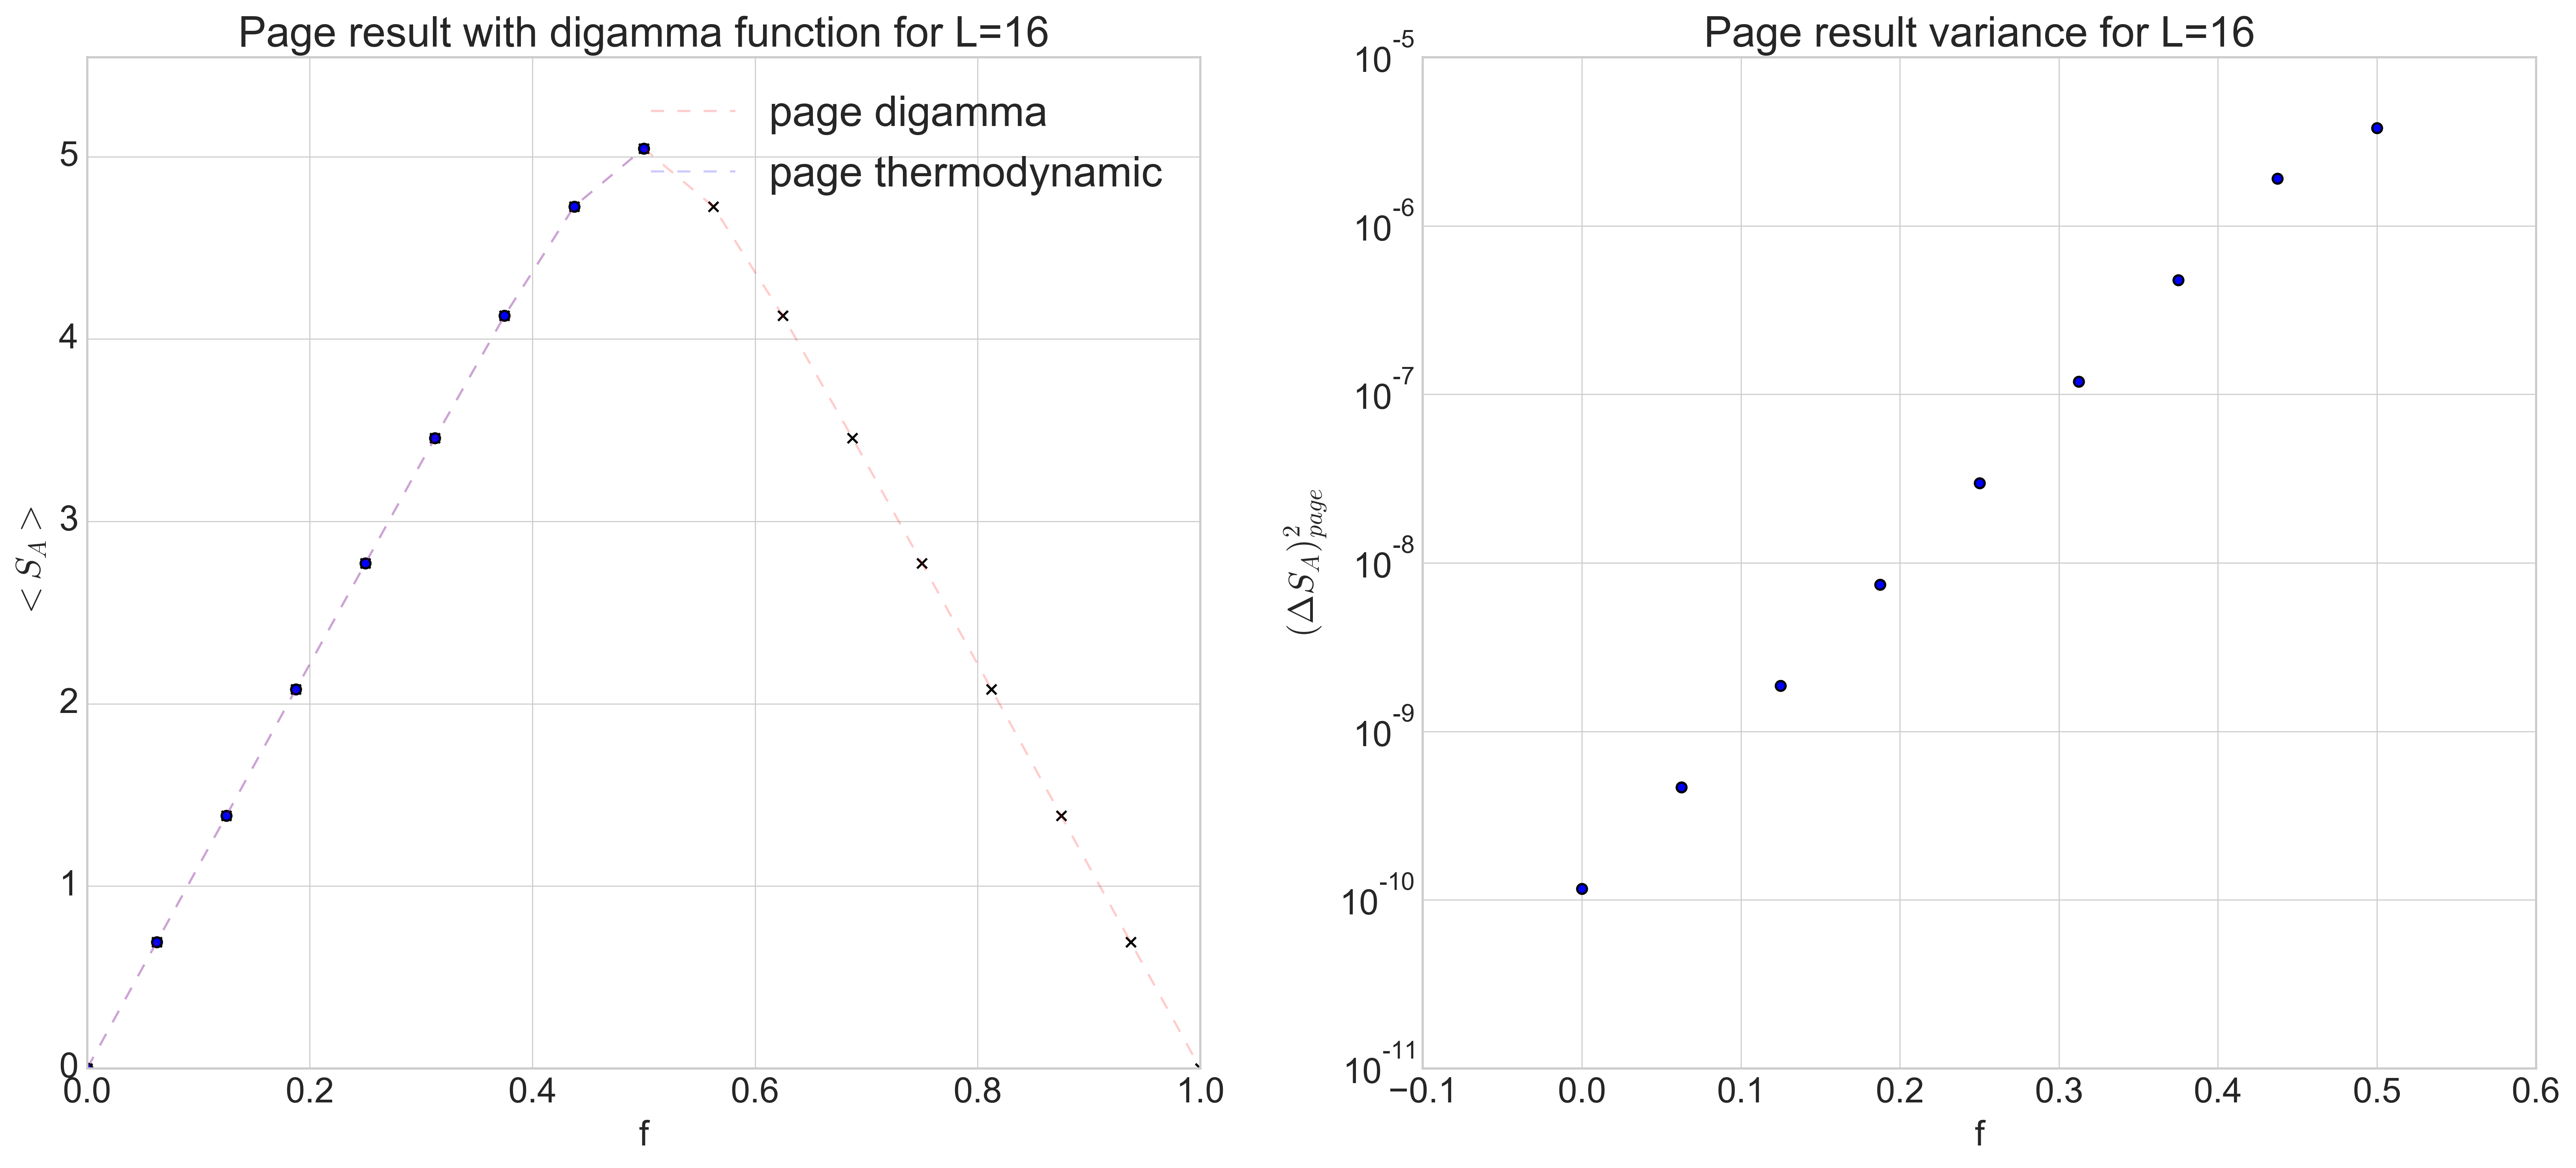

In [6]:
def plot_page(L, legend = True):
    N = np.power(2, L)
    fig, ax = plt.subplots(1,2, figsize = (20,8))
    ax[0].set_xlabel("f")
    ax[1].set_xlabel("f")
    ax[0].set_ylabel("$<S_A>$")
    ax[1].set_ylabel("$(\Delta S_A )^2 _{page}$")
    constant = 1
    constant2 = 10000/L
    
    points = []
    pages = []
    pages_thermo = []
    for L_a in np.arange(0, L+1):
        d_a = np.power(2, L_a)
        d_b = np.power(2, L-L_a)
        f=L_a/L
        page = page_result(d_a, d_b)
        page_var = page_result_var(d_a, d_b)
        page_therm = page_thermodynamic(f, L, constant)
        page_therm_var = page_thermodynamic_var(f, L, constant2)
        
        ax[0].scatter(f, page, c='black', marker ='x')
        if(L_a <= L//2):
            ax[0].scatter(f, page_therm, c='blue', marker ='o')
            #ax[1].scatter(f, page_var, c='black', marker ='x')
            ax[1].scatter(f, page_therm_var, c='blue',marker ='o')
        
        points.append(f)
        pages.append(page)
        
        pages_thermo.append(page_therm)
        
    ax[0].plot(points, pages, color='red', ls = '--', alpha = 0.2, label = "page digamma")
    ax[0].plot(points[0:-L//2], pages_thermo[0:-L//2], color='blue', ls = '--', alpha = 0.2, label = "page thermodynamic")
    if legend:
        ax[0].legend()
    ax[0].set_title(f"Page result with digamma function for L={L}")
    ax[1].set_title(f"Page result variance for L={L}")
    
    ax[1].set_yscale('log')
    ax[0].set_xlim([0, 1])
    ax[0].set_ylim([0, 1/2 * L * np.log(2) + constant * np.power(2., -L)])
    return ax
plot_page(16)

## Many Page's results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([[<AxesSubplot:title={'center':'Average entropy over different lattice sizes'}, xlabel='f', ylabel='$<S_A>$'>,
         <AxesSubplot:title={'center':'Average entropy density over different lattice sizes'}, xlabel='f', ylabel='$<S_A>/V$'>],
        [<AxesSubplot:title={'center':'Average entropy variance over different lattice sizes'}, xlabel='f', ylabel='$(\\Delta S_A )^2$'>,
         <AxesSubplot:title={'center':'Entropy samples for different system sizes'}, xlabel='$f$', ylabel='$<S_A>$'>]],
       dtype=object),
 {10: 'o', 14: 's', 18: 'v', 20: '+'},
 {10: 'tab:red', 14: 'tab:purple', 18: 'tab:brown', 20: 'tab:pink'})

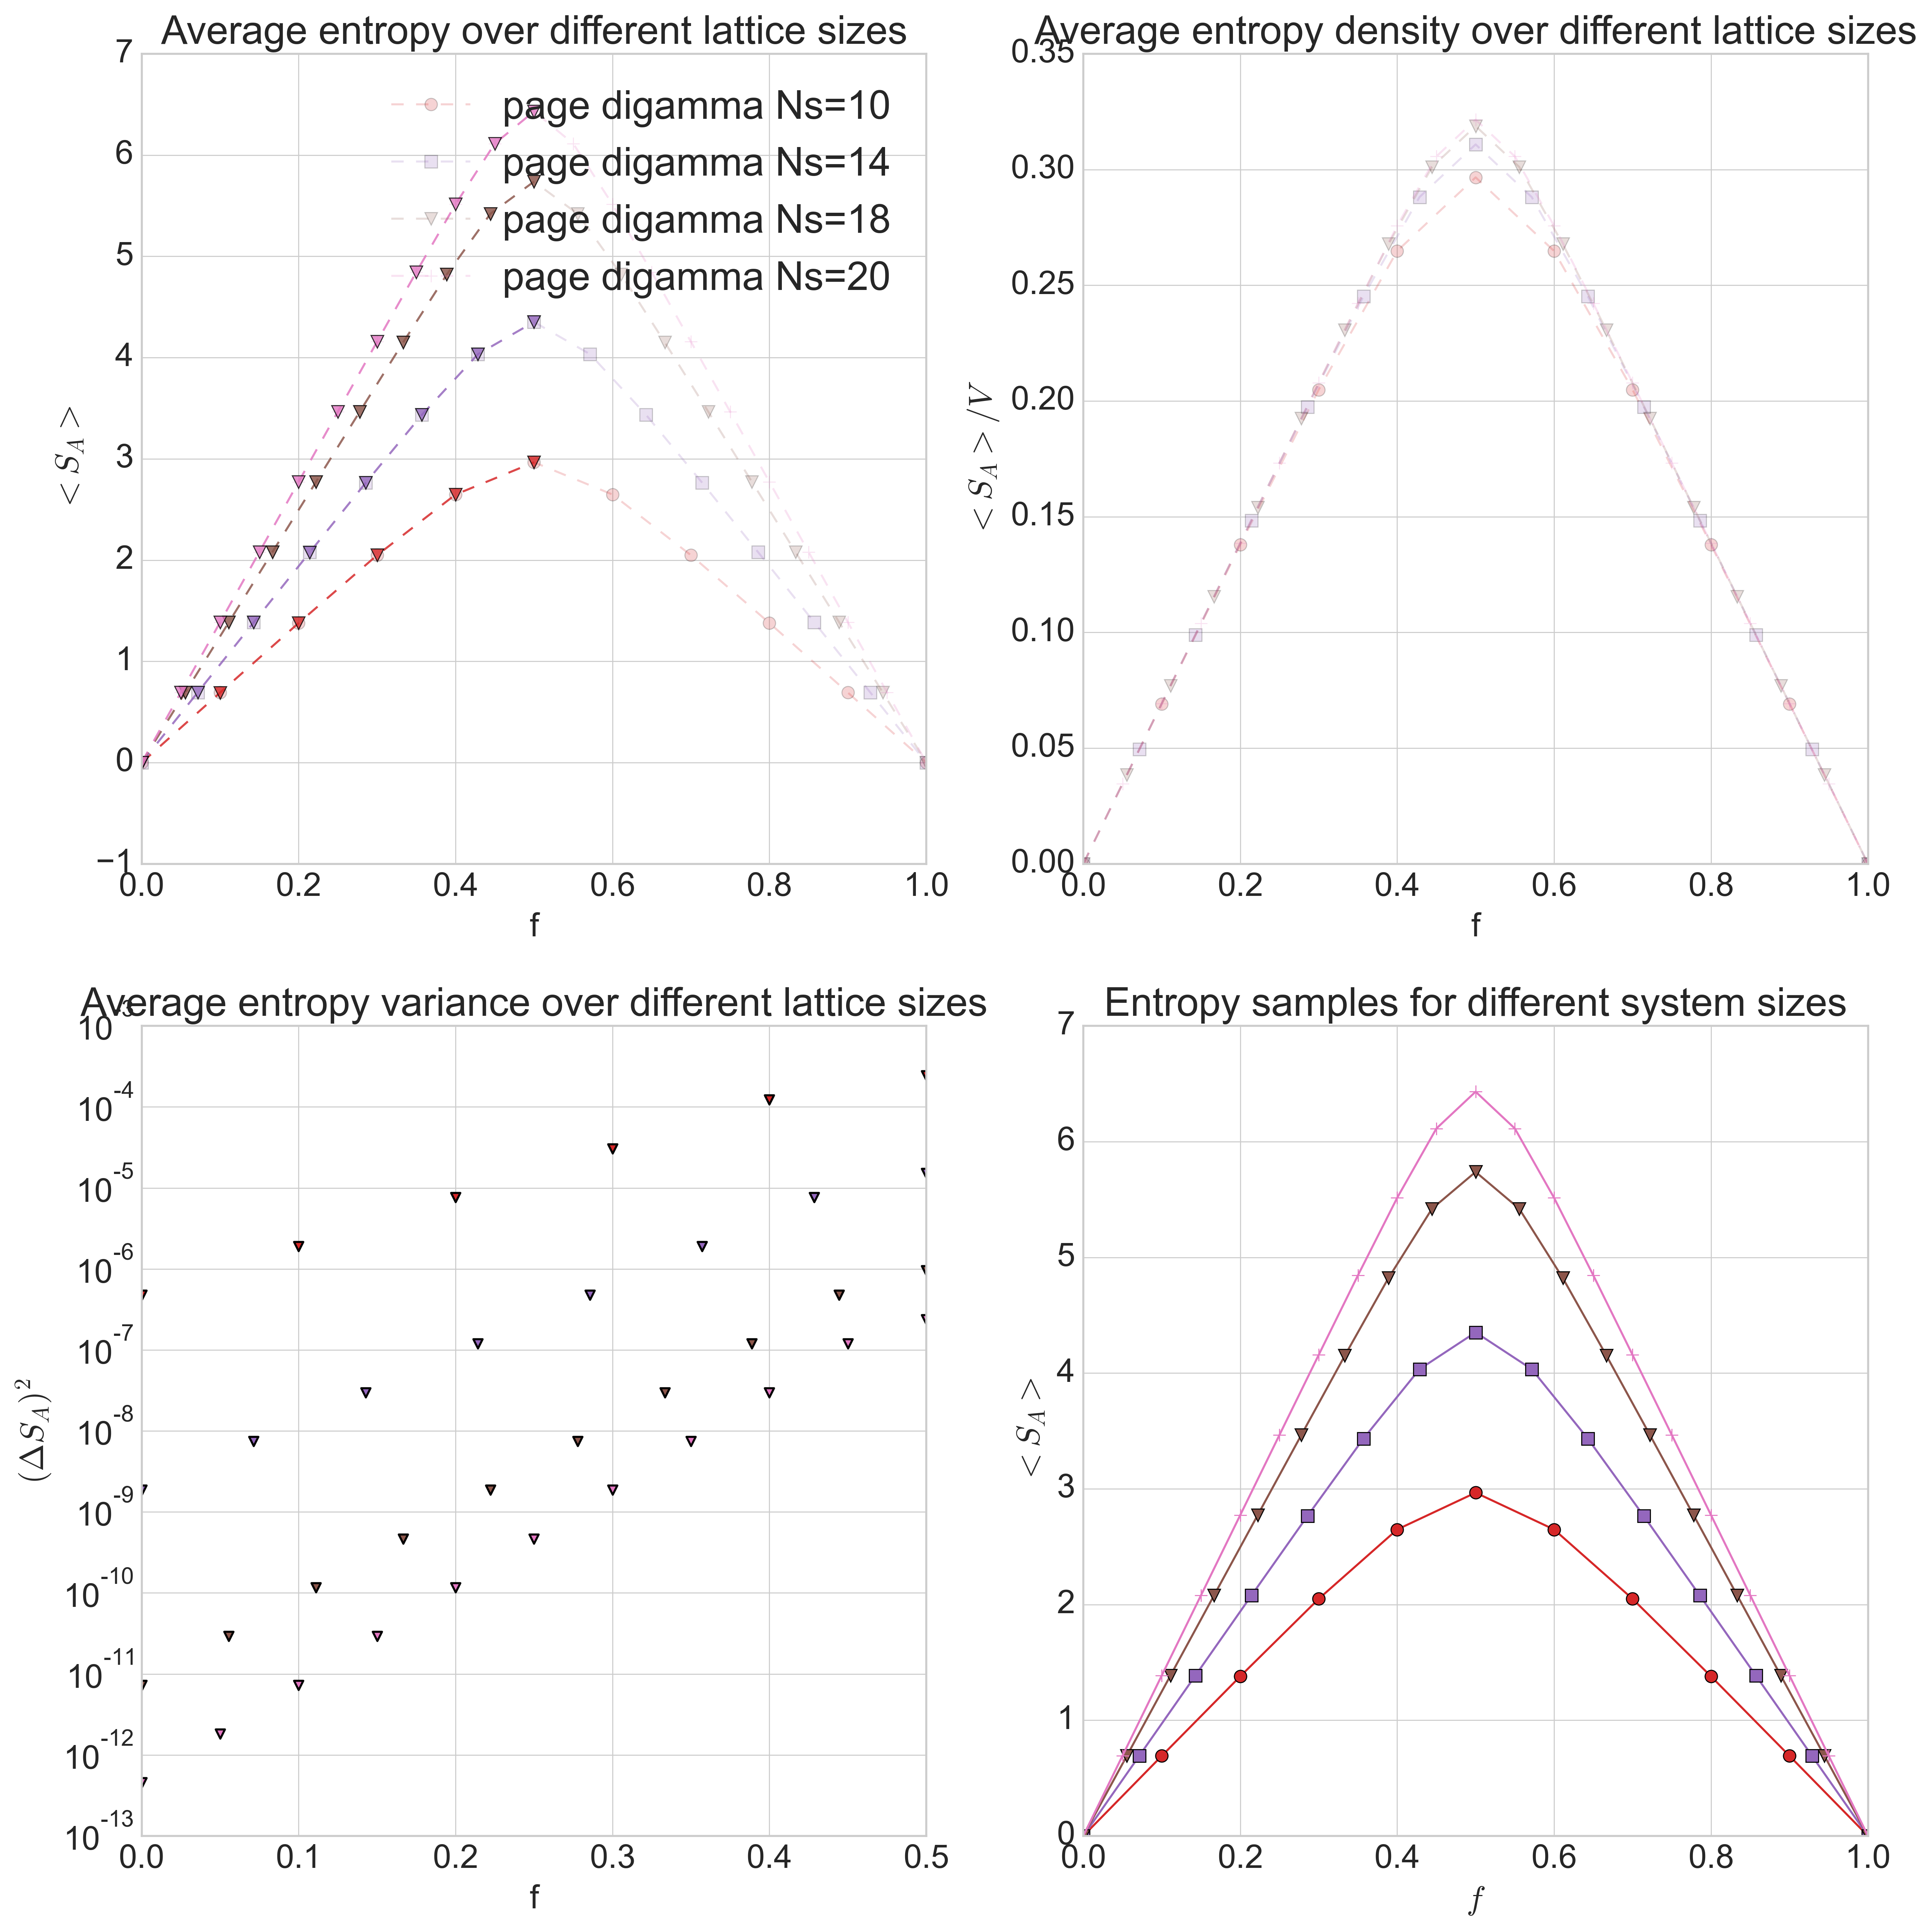

In [7]:
def plot_pages(L, legend = True):
    fig, ax = plt.subplots(2,2, figsize = (15,15))
    
    ax[0][0].set_xlim([0, 1])
    ax[0][0].set_xlabel("f")
    ax[0][0].set_ylabel("$<S_A>$")
    ax[0][0].set_title(f"Average entropy over different lattice sizes")
    
    ax[0][1].set_xlim([0, 1])
    ax[0][1].set_xlabel("f")
    ax[0][1].set_ylabel("$<S_A>/V$")
    ax[0][1].set_title(f"Average entropy density over different lattice sizes")
    ax[0][1].set_ylim([0, np.log(2) * 1/2])
    ax[0][1].set_yticks([0.05 * i for i in range(0, 8)])
    
    ax[1][0].set_xlim([0, 0.5])
    ax[1][0].set_yscale('log')
    ax[1][0].set_xlabel("f")
    ax[1][0].set_ylabel("$(\Delta S_A )^2$")
    ax[1][0].set_title(f"Average entropy variance over different lattice sizes")
    
    ax[1][1].set_xlim([0, 1])
    ax[1][1].set_xlabel("$f$")
    ax[1][1].set_ylabel("$<S_A>$")
    ax[1][1].set_title("Entropy samples for different system sizes")
    
    col = {}
    mark = {}
    
    for l in L:  
        N = np.power(2, l)
    
        points = []
        pages = []
        pages_thermo = []
        
        color_page = next(colors_ls_cyc)
        marker_page = next(markers)
        color_page_therm = color_page
        marker_page_therm = 'v'
        for L_a in np.arange(0, l+1):
            d_a = np.power(2, L_a)
            d_b = np.power(2, l-L_a)
            f=L_a/l
            
            mark[l] = marker_page
            col[l] = color_page
            
            page = page_result(d_a, d_b)
            page_var = page_result_var(d_a, d_b)
            page_therm = page_thermodynamic(f, l, 1)
            page_therm_var = page_thermodynamic_var(f, l, 1)
            
            if(L_a <= l//2):
                #ax[1][0].scatter(f, page_var, c=color_page, marker = marker_page)
                ax[1][0].scatter(f, page_therm_var, c=color_page_therm, marker = marker_page_therm)
            
            points.append(f)
            pages.append(page)
            pages_thermo.append(page_therm)
        
        ax[0][0].plot(points, pages, color=color_page, marker = marker_page, ls = '--',
                   alpha = 0.2, label = f"page digamma Ns={l}")
        
        ax[0][0].plot(points[0:-l//2], pages_thermo[0:-l//2], color=color_page_therm,
                   marker = marker_page_therm, ls = '--',
                   alpha = 0.8)
                
        ax[0][1].plot(points, np.array(pages)/l, color=color_page, marker = marker_page, ls = '--',
                    alpha = 0.2)
       
        ax[1][1].plot(points, pages, color=color_page, marker = marker_page, ls = '-',
                   alpha = 1.0)


    if legend:
        ax[0][0].legend()
        ax[0][1].legend()
        ax[1][0].legend()
        ax[1][1].legend()
        
    return ax, mark, col
plot_pages([10,14,18,20])

## Averages plot

In [8]:
# standard maximum value
page_difference = lambda x, l: np.array(1/2 * l * np.log(2) - 1/2 - x).flatten()
# page results value not in thermodynamic limit
digamma_difference = lambda x, l: np.array(page_result(np.power(2, l//2), np.power(2, l//2)) - x).flatten()

# page results value not in thermodynamic limit
digamma_difference_v = lambda x, l: np.array(x-page_result_var(np.power(2, l//2), np.power(2, l//2))).flatten()

In [9]:
def plot_all(L, model : ising_transverse, frac, directory):
    fig, ax = plt.subplots(figsize = (10,10))
    ax.set_xlabel('Energy')
    ax.set_ylabel('S(E)')
    
    for l in L:
        model.set_Ns(l)
        model.set_mean_energy(directory)
        #print(model.get_info())
        entropies, _ = model.get_entropies_file(frac, directory)
        energies, _ = model.get_energy_file(directory)
        if energies.empty or entropies.empty:
            continue
        #print(entropies.columns, model.N)
        energies = np.array(energies.iloc[int(entropies.columns[1]-1):int(entropies.columns[-1])+1]).flatten()
        entropies = np.array(entropies[entropies['L_a']==0.5][entropies.columns[1:]].T).flatten()
        #print(len(energies), len(entropies))   
        color = next(colors_ls_cyc)                   
        ax.scatter(np.array(energies), np.array(list(entropies)),
                   label = model.get_info(),
                   c = color, marker=next(markers))
        ax.axhline(y = page_result(np.power(2.0, l//2), np.power(2.0, l//2)), color = color)
    ax.set_ylim([0, page_result(np.power(2.0, max(L)//2), np.power(2.0, max(L)//2))+0.2])
    ax.legend(fontsize = 10)

In [10]:
def plot_model_av(model, frac, directory = f"{kPSep}resultsSym"):
    df, fraction = model.get_averages_file(frac, directory)
    df_var, fraction = model.get_variance(frac, directory)
    ax = plot_page(model.Ns, False)
    ax[0].plot(df['L_a'], df['av_S'], label = model.get_info())
    ax[1].plot(df_var['L_a'], df_var['var'], label = model.get_info(), marker = 'x')
    ax[0].legend()
    ax[1].legend()
    return df, fraction
    
def plot_many_scatters(df, ax, color, marker, l, label):
    minima = []
    averages = []
    seventy_fives = []
    quoters = []
    pages = []
    for col in df.columns[1:]:
        x = [float(col) for i in range(len(df))]
        ax.scatter(x, np.array(df[col]), color = color, marker = marker, s = 2, alpha = 0.1)
        minima.append(np.min(np.array(df[col])))
        averages.append(np.average(np.array(df[col])))
        seventy_fives.append(np.quantile(np.array(df[col]),0.75))
        quoters.append(np.quantile(np.array(df[col]), 0.25))
    # pages only
    for L_a in np.arange(1, l//2 + 1):
        d_a = np.power(2, L_a)
        d_b = np.power(2, l-L_a)
        pages.append(page_result(d_a, d_b))
        
    x = [i/l for i in range(1,l//2+1)]
    
    alpha = 0.05
    ax.fill_between(np.array(x), minima, pages, color=color, alpha=alpha, interpolate=False)
    alpha *= 2
    ax.fill_between(np.array(x), seventy_fives, pages, color=color, alpha=alpha, interpolate=False)
    alpha *= 2
    ax.fill_between(np.array(x), averages, pages, color=color, alpha=alpha, interpolate=False)
    alpha *= 2
    ax.fill_between(np.array(x), quoters, pages, color=color, alpha=alpha, interpolate=False, label = label)

def plot_model_avs(L, model, frac, directory = f"{kPSep}resultsSym", sector = 'all'):
    ax, markers, colors = plot_pages(L, False)
    
    df = pd.DataFrame()
    df_var = pd.DataFrame()
    df_all = pd.DataFrame()
    for l in L:
        model.set_Ns(l)
        model.set_mean_energy(directory)
        
        label = model.get_info() if sector=='single' else model.get_info_wo_sym()
        
        # check how many sectors do we wanto to get
        if sector == 'single':
            df, fraction = model.get_averages_file(frac, directory)
            df_var, fraction = model.get_variance(frac, directory)
            df_all = model.concat_entropies(frac, directory, sector)
        else:
            df, fraction = model.average_symmetry_sectors(frac, directory, sector, False)
            df_var, fraction = model.average_symmetry_sectors(frac, directory, sector, True)
            df_all = model.concat_entropies(frac, directory, sector)
        
        plot_many_scatters(df_all, ax[1][1], colors[l], markers[l], l, label = label)            
        ax[0][0].plot(df['L_a'], df['av_S'], label = label, color = colors[l], marker=markers[l])
        ax[0][1].plot(df['L_a'], df['av_S']/l, label = label, color = colors[l], marker=markers[l])
        ax[1][0].plot(df_var['L_a'], df_var['var'], label = label, color = colors[l], marker=markers[l])
        
    # plot the lines
    inverse_L = 1.0/np.array(L)
    label = "_" + model.get_info()[6:] if sector=='single' else model.get_info_wo_sym()[6:]
       
    average_name = "ED states" if not model.sym else (f"single sector {(model.k, model.p)}" if sector=='single' else sector)
    
    fontsize = 12
    
    ax[0][0].set_title(f"Average entropy over {average_name} for different system sizes - v={frac}", fontsize = fontsize)
    ax[0][1].set_title(f"Average entropy density over {average_name} for different system sizes - v={frac}", fontsize = fontsize)
    ax[1][0].set_title(f"Average entropy variance over {average_name} for different system sizes - v={frac}", fontsize = fontsize)
    ax[1][1].set_title(f"Entropy samples over {average_name} for different system sizes - v={frac}", fontsize = fontsize)
    
    fontsize = 11.5
    ax[0][0].legend(loc='lower center', fontsize = 7)
    ax[0][1].legend(loc='lower center', fontsize = fontsize)
    ax[1][0].legend(loc='lower right', fontsize = fontsize)
    ax[1][1].legend(loc='lower center', fontsize = fontsize)
    plt.savefig(directory + label + f",frac={frac},sector={sector},L={L}.png", facecolor='white')

def plot_fit(values, x, ax, label, color, fit_fun):
    # extract the power law behavior
    #log_val = np.log(values)
    #log_1_ov_x = np.log(1/x)
    #funct=(lambda x, a : np.power(1.0/x, a))
    #popt1, pcov1 = curve_fit(funct, 1.0/x, values)
    #print(popt1)

    
    #print(x, 1.0/x, values)
    
    param_bounds= ([0, -np.inf, 0],[np.inf,np.inf, min(values)]) if (fit_fun == fit_one_over_v2) else ([-np.inf, 0],[np.inf, min(values)])
    popt, pcov = curve_fit(fit_fun, 1.0/x, values, bounds=param_bounds)
    
    xran = np.arange(10.0, 1e5, 2)
    #fit_val = fit_one_over_v(xran, popt[0], popt[1], popt[2])
    #fit_val = fit_one_over_v(xran, popt[0], popt[1])
    fit_val = fit_fun(xran, *popt)
    #print(xran[0:5], 1.0/xran[0:5],fit_val[0:5])
    #ax.plot(1.0/xran,funct(xran, *popt1), '--', color = color, alpha = 0.5)
    ax.plot(1.0/xran, fit_val, '--', color = color, alpha = 0.5)
    ax.scatter(1.0/np.max(xran), fit_fun(np.max(xran), *popt), s = 25, c = color)
    text = f'{label}:{popt}'
    return text, popt

def plot_difference_cloud(L, fractions, model : ising_transverse, directory = f"{kPSep}resultsSym",
                          system_frac = 0.5, xscale = 'linear', yscale = 'linear', ylim = [1e-2, 1], fit_fun = fit_one_over_v,
                          avs = 'av_So', dif_fun = digamma_difference):
    
    fun_name = "1ovV" if fit_fun == fit_one_over_v else "1ovV2"
    dif_fun_name = "digamma" if dif_fun == digamma_difference else "page"
    
    fig, ax = plt.subplots(2, 2, figsize = (18,18))
    color_real, color_other, color_obc = tuple(random.sample(colors_ls, 3))
    marker_real, marker_other, marker_obc = tuple(random.sample(markers_ls, 3))
    
    
    L_obc = [10, 12, 14, 16]
    inverse_L = 1.0/np.array(L)
    xlim = [0, 1.0/(np.min(L_obc))]
    yticks = [1, 5e-1, 1e-1, 5e-2, min(ylim)]
    ylabels = [str(i) for i in yticks]
    xticks = [0.0] + list(1.0/np.array(np.arange(np.min(L_obc)-2, np.max(L)+2, 2)))
    xlabels = [0] + [f'1/{i}' for i in np.arange(np.min(L_obc)-2, np.max(L)+2, 2)]#f'1/{i}' for i in ([100] + L)]
    
    ax[0][0].set_yscale(yscale)
    ax[0][0].set_xscale(xscale)
    #ax[0][0].set_yticks(yticks, ylabels)
    ax[0][0].set_xticks(xticks, xlabels, rotation = -45)
    if xscale == 'linear':
        ax[0][0].set_xlim(xlim)
    #ax[0][0].set_ylim(ylim)
    ax[0][0].set_xlabel("$1/V$", fontsize = 16)
    ax[0][0].set_ylabel("$S_{max} - <S_A>_{sec}$", fontsize = 16)
    ax[0][0].set_title("$[0.5*V*\ln{2} - 0.5] - <S_A>$ for different sectors. " + f"ν = {fractions[0]}.", fontsize = 14)
    
    ax[0][1].set_yscale(yscale)
    ax[0][1].set_xscale(xscale)  
    ax[0][1].set_xlabel("$1/V$")
    #ax[0][1].set_yticks(yticks, ylabels)
    ax[0][1].set_xticks(xticks, xlabels, rotation = -45)
    if xscale == 'linear':
        ax[0][1].set_xlim(xlim)
    ax[0][1].set_ylim(ylim)
    ax[0][1].set_ylabel("$S_{max} - <S_A>_{min}^{ν}$", fontsize = 16)
    ax[0][1].set_title("$[0.5*V*\ln{2} - 0.5] - <S_A>_{sec}$, different # of states ν.", fontsize = 14)
    
    ax[1][0].set_yscale(yscale)
    ax[1][0].set_xscale(xscale)
    #ax[1][0].set_yticks(yticks, ylabels)
    ax[1][0].set_xticks(xticks, xlabels, rotation = -45)
    if xscale == 'linear':
        ax[1][0].set_xlim(xlim)
    ax[1][0].set_ylim(ylim)
    ax[1][0].set_xlabel("$1/V$")
    ax[1][0].set_ylabel("$S_{\Psi} - <S_A>_{sec}$", fontsize = 15)
    ax[1][0].set_title("$[\Psi(d_Ad_B+1) - \Psi(d_B + 1) - (d_A - 1)/(2d_B)] - <S_A>$\n for different sectors - " + f"ν = {fractions[0]}.", fontsize = 14)

    ax[1][1].set_yscale(yscale)
    ax[1][1].set_xscale(xscale)
    #ax[1][1].set_yticks(yticks, ylabels)
    ax[1][1].set_xticks(xticks, xlabels, rotation = -45)
    if xscale == 'linear':
        ax[1][1].set_xlim(xlim)
    ax[1][1].set_ylim(ylim)
    ax[1][1].set_xlabel("$1/V$", fontsize = 16)
    ax[1][1].set_ylabel("$S_{max} - \overline{<S_A>}^{ν}$", fontsize = 16)
    ax[1][1].set_title("$[0.5*V*\ln{2} - 0.5] - <S_A>$ averaged over sectors - " + f"ν = {fractions[0]}", fontsize = 14)
    
    
    # last plot with all together
    real_0, img_0, obc_0, real_1, img_1, obc_1 = None, None, None, None, None, None
    av_real = []
    av_other = []
    av_together = []
    av_obc = []

    marker_s = 20
    frac_df = pd.DataFrame(index=fractions, columns = L if avs != 'av_Sobc' else L_obc)
    for col in frac_df.columns:
        frac_df[col].values[:] = 1e10

    print("----------------------> STARTING PBC <----------------------\n\n")  
    # --------------------------------------------------- PBC -----------------------------------------------
    for i, l in enumerate(L):
        model.bc = 0
        model.set_Ns(l)
        model.set_mean_energy(directory)
        # left of fractions will be used for the left plot
        
        # real sectors
        real_sectors = model.real_symmetries_str
        # if plotted all already for the first fraction number
        plotted_all = False
        
        # over Hilbert state fractions
        for idx, frac in enumerate(fractions):            
            df = model.get_all_symmetry_sectors(frac, directory, var = False)
            row = df[df['L_a']==1/2].loc[:,df.columns[1:]]
            
            #print(f'for l = {l}, frac = {frac} row = ')
            #print(row)
            
            if row.empty: continue
            
            real_columns = []
            other_columns = []
            for col in row.columns:
                sym = col.split(":")[0]
                if sym in real_sectors:
                    real_columns.append(col)
                else:
                    other_columns.append(col)

            # find the minimum over various sectors
            #print(row)
            row_real = np.array(row[real_columns]).flatten()
            row_other = np.array(row[other_columns]).flatten()
            
            #diff = page_difference(np.array(row), l)
            #min_elem = np.min(diff)
            #print(f"min_elem={min_elem}")
            all = model.average_symmetry_sectors_df(row)
            if avs != 'av_Sobc':
                frac_df.loc[frac,l] = dif_fun(np.array(all[avs])[0], l)
            #minima.append(min_elem)
        
            # plot cloud
            if not plotted_all:
                # append for the last plot
                
                av_real.append(np.array(all['av_Sr'])[0])
                av_other.append(np.array(all['av_So'])[0])
                av_together.append(np.array(all['av_S'])[0])
                
                
                # real
                x_values = np.repeat(1.0/l, len(row_real))
                real_0 = ax[0][0].scatter(x_values, page_difference(row_real, l), marker = marker_real, color = color_real, s=marker_s)
                real_1 = ax[1][0].scatter(x_values, digamma_difference(row_real, l), marker = marker_real, color = color_real, s=marker_s)
                
                # other
                x_values = np.repeat(1.0/l, len(row_other))
                img_0 = ax[0][0].scatter(x_values, page_difference(row_other, l), marker = marker_other, color = color_other, s=marker_s)
                img_1 = ax[1][0].scatter(x_values, digamma_difference(row_other, l), marker = marker_other, color = color_other, s=marker_s)
                
                # skip other fractions
                plotted_all = True
                
    
    print("----------------------> STARTING OBC <----------------------\n\n")            
    # --------------------------------------------------- OBC -----------------------------------------------
    for i, l in enumerate(L_obc):
        model.bc = 1
        model.set_Ns(l)
        model.set_mean_energy(directory)
        # left of fractions will be used for the left plot
        
        # left of fractions will be used for the left plot
        
        plotted_all = False
        # over Hilbert state fractions

        for idx, frac in enumerate(fractions):      
            
            obc = model.get_all_symmetry_sectors(frac, directory, var = False)
            row_obc = obc[obc['L_a']==1/2].loc[:,obc.columns[1:]]
            
            if row_obc.empty: continue

            all = model.average_symmetry_sectors_df(row_obc)
            #minima.append(min_elem)
            if avs == 'av_Sobc':
                frac_df.loc[frac,l] = dif_fun(np.array(all['av_S'])[0], l)
            # plot cloud
                # take the obc values ----------------------------------------------------
            if not plotted_all:
                row_obc = np.array(row_obc).flatten()
                x_values = np.repeat(1.0/l, len(row_obc))
                obc_0 = ax[0][0].scatter(x_values, page_difference(row_obc, l), marker = marker_obc, color = color_obc, s=marker_s)
                obc_1 = ax[1][0].scatter(x_values, digamma_difference(row_obc, l), marker = marker_obc, color = color_obc, s=marker_s)
                
                if len(all) != 0:
                    av_obc.append((l,np.array(all['av_S'])[0]))
                plotted_all = True
            if avs != 'av_Sobc':
                break

    # --------------------------------------------------- FITS ----------------------------------------------
    fits = {}
    marker_s = 8
    # plot averages
    L = np.array(L)
    
    color = next(colors_ls_cyc)
    values = np.array([dif_fun(av_real[i], L[i]) for i in range(len(L))]).flatten()
    t, popt = plot_fit(values[np.isfinite(values)], inverse_L[np.isfinite(values)], ax[1][1], '', color, fit_fun)
    ax[1][1].plot(inverse_L, values, marker = next(markers), color = color, label = f"real sectors, fit:{t}", markersize=marker_s)
    fits['real']=popt
    
    color = next(colors_ls_cyc)
    values = np.array([dif_fun(av_other[i], L[i]) for i in range(len(L))]).flatten()
    t, popt = plot_fit(values[np.isfinite(values)], inverse_L[np.isfinite(values)], ax[1][1], '', color, fit_fun)
    ax[1][1].plot(inverse_L, values, marker = next(markers), color = color, label = f"imaginary sectors, fit:{t}", markersize=marker_s)
    fits['img']=popt
    
    color = next(colors_ls_cyc)
    values = np.array([dif_fun(av_together[i], L[i]) for i in range(len(L))]).flatten()
    t, popt = plot_fit(values[np.isfinite(values)], inverse_L[np.isfinite(values)], ax[1][1], '', color, fit_fun)
    ax[1][1].plot(inverse_L, values, marker = next(markers), color = color, label = f"all sectors, fit:{t}", markersize=marker_s)
    fits['all']=popt
    
    # plot obc
    ls = np.array([av_obc[i][0] for i in range(len(av_obc))])
    color = next(colors_ls_cyc)
    values = np.array([dif_fun(av_obc[i][1], av_obc[i][0]) for i in range(len(av_obc))]).flatten()
    t, popt = plot_fit(values, 1/ls, ax[1][1], '', color, fit_fun)
    ax[1][1].plot(1/ls, values, marker = next(markers), color = color, label = f"obc sectors, fit:{t}", markersize=marker_s)
    fits['obc']=popt
    
    l = 100
    fits_av = {}
    for i, row in frac_df.iterrows():
        color=next(colors_ls_cyc)
        lim = page_their(l//2, l) - their_result(i, l)
        ax[0][1].plot(inverse_L, row, marker = next(markers), color = color, label=f"ν={i}")
        t, popt = plot_fit(np.array(row), inverse_L, ax[0][1], '', color, fit_fun)
        txt = f"limit : {lim:.4f},v={i}. fit: {popt}"
        ax[0][1].axhline(y=lim, color = color, linestyle='--', alpha = 0.3, label = txt)
        fits_av[i] = popt

    # plot limit according to Nuclear Physics B 966(2021)
    l = 100
    fontsize = 13.5
    limit = page_their(l//2, l) - their_result(fractions[0], l)
    text = f"limit : {limit:.4f},v={fractions[0]}"
    lim = ax[0][0].axhline(y=limit, color='blue', linestyle='--', alpha = 0.8)
    ax[0][0].legend([real_0, img_0, obc_0, lim], ['real sectors', 'imaginary sectors', 'obc sectors', text], fontsize = fontsize, loc = 'upper left')

    ax[0][1].legend(fontsize = 7.5, loc = 'best')
    
    lim = ax[1][0].axhline(y=limit, color='blue', linestyle='--', alpha = 0.8) 
    ax[1][0].legend([real_1, img_1, obc_1, lim], ['real sectors', 'imaginary sectors', 'obc sectors', text], fontsize = fontsize, loc = 'best')
    
    ax[1][1].axhline(y=limit, color='blue', linestyle='--', alpha = 0.8, label = text)
    ax[1][1].legend(fontsize = 7.5, loc='best')

    model.bc=0
    plt.savefig(directory + f"_diff_xscale={xscale}_" + model.get_info_wo_sym()[6:] + f",L={L},frac={fractions},fit{fun_name},avs={avs},dif_fun={dif_fun_name}.png", facecolor='white')
    plt.show()
    return frac_df, fits, fits_av

def plot_variances(L, fractions, model : ising_transverse, directory = f"{kPSep}resultsSym", system_frac = 0.5, dif_fun = digamma_difference_v):
    fig, ax = plt.subplots(2, figsize = (15,15))
    dif_fun_name = "digamma_var" if dif_fun == digamma_difference_v else "page_var"
    
    color_real, color_other, color_obc = tuple(random.sample(colors_ls, 3))
    marker_real, marker_other, marker_obc = tuple(random.sample(markers_ls, 3))
    
    inverse_L = 1.0/np.array(L)
    xlim = [0, 1.0/(np.min(L)-2)]
    ylim = [3e-2, 0.5]
    yticks = [1, 5e-1, 1e-1, 5e-2, min(ylim)]
    ylabels = [str(i) for i in yticks]
    xticks = [0.0] + list(inverse_L)
    xlabels = [0] + [f'1/{i}' for i in L]#f'1/{i}' for i in ([100] + L)]
    
    ax[0].set_yscale('log')
    ax[0].set_xscale('linear')
    #ax[0][0].set_yticks(yticks, ylabels)
    ax[0].set_xticks(xticks, xlabels, rotation = -45)
    ax[0].set_xlim(xlim)
    #ax[0].set_ylim(ylim)
    ax[0].set_xlabel("$1/V$", fontsize = 16)
    ax[0].set_ylabel("$S_{max} - <S_A>_{sec}$", fontsize = 16)
    ax[0].set_title("$(\Delta S_A)^2 _{page} - (\Delta S_A) ^2$ for different sectors. " + f"ν = {fractions[0]}.", fontsize = 14)

    ax[1].set_yscale('log')
    ax[1].set_xscale('linear')
    #a][0].set_yticks(yticks, ylabels)
    ax[1].set_xticks(xticks, xlabels, rotation = -45)
    ax[1].set_xlim(xlim)
    #a][0].set_ylim(ylim)
    ax[1].set_xlabel("$1/V$", fontsize = 16)
    ax[1].set_ylabel("$S_{max} - <S_A>_{sec}$", fontsize = 16)
    ax[1].set_title("$(\Delta S_A)^2 _{page} - (\Delta S_A)^2$ for averaged sectors. " + f"ν = {fractions[0]}.", fontsize = 14)
    
    
    av_real = []
    av_other = []
    av_together = []
    av_obc = []
    real, img, obc = None, None, None
    marker_s = 20
    print("----------------------> STARTING PBC <----------------------\n\n")  
# --------------------------------------------------- PBC --------------------------------------------------
    for i, l in enumerate(L):
        model.bc = 0
        model.set_Ns(l)
        model.set_mean_energy(directory)
        # left of fractions will be used for the left plot
        
        # real sectors
        real_sectors = model.real_symmetries_str
        # if plotted all already for the first fraction number
        plotted_all = False
        
        # over Hilbert state fractions
        for idx, frac in enumerate(fractions):
            # get variances            
            df = model.get_all_symmetry_sectors(frac, directory, var = True)
            row = df[df['L_a']==1/2].loc[:,df.columns[1:]]
            if row.empty: continue
            
            real_columns = []
            other_columns = []
            for col in row.columns:
                sym = col.split(":")[0]
                if sym in real_sectors:
                    real_columns.append(col)
                else:
                    other_columns.append(col)

            # find the minimum over various sectors
            #print(row)
            row_real = np.array(row[real_columns]).flatten()
            row_other = np.array(row[other_columns]).flatten()
        
            # plot cloud
            if not plotted_all:
                # append for the last plot
                all = model.average_symmetry_sectors_df(row)
                av_real.append(np.array(all['av_Sr'])[0])
                av_other.append(np.array(all['av_So'])[0])
                av_together.append(np.array(all['av_S'])[0])
                
                # real
                x_values = np.repeat(1.0/l, len(row_real))
                real = ax[0].scatter(x_values, dif_fun(row_real, l), marker = marker_real, color = color_real, s=marker_s)
                
                # other
                x_values = np.repeat(1.0/l, len(row_other))
                img = ax[0].scatter(x_values, dif_fun(row_other, l), marker = marker_other, color = color_other, s=marker_s)
                
                # skip other fractions
                plotted_all = True
    print("----------------------> STARTING OBC <----------------------\n\n")  
 # --------------------------------------------------- OBC --------------------------------------------------
    for i, l in enumerate(L):
        model.bc = 1
        model.set_Ns(l)
        model.set_mean_energy(directory)
        
        # over Hilbert state fractions
        frac = fractions[0]
        # get variances            
        df = model.get_all_symmetry_sectors(frac, directory, var = True)
        row = df[df['L_a']==1/2].loc[:,df.columns[1:]]
        
        if row.empty: continue
        
        # plot cloud
        all = model.average_symmetry_sectors_df(row)
        row_obc = np.array(row).flatten()
        x_values = np.repeat(1.0/l, len(row_obc))
        obc = ax[0].scatter(x_values, dif_fun(row_obc, l), marker = marker_obc, color = color_obc, s=marker_s)
        
        if len(all) != 0:
            av_obc.append((l,np.array(all['av_S'])[0]))



    marker_s = 8
    # plot averages
    L = np.array(L)
    values = np.array([dif_fun(av_real[i], L[i]) for i in range(len(L))]).flatten()
    ax[1].plot(inverse_L, values, marker = next(markers), color = next(colors_ls_cyc), label = f"real sectors", markersize=marker_s)
    
    values = np.array([dif_fun(av_other[i], L[i]) for i in range(len(L))]).flatten()
    ax[1].plot(inverse_L, values, marker = next(markers), color = next(colors_ls_cyc), label = f"imaginary sectors", markersize=marker_s)
    
    values = np.array([dif_fun(av_together[i], L[i]) for i in range(len(L))]).flatten()
    ax[1].plot(inverse_L, values, marker = next(markers), color = next(colors_ls_cyc), label = f"all sectors", markersize=marker_s)
    # plot obc
    ls = np.array([av_obc[i][0] for i in range(len(av_obc))])
    values = np.array([dif_fun(av_obc[i][1], av_obc[i][0]) for i in range(len(av_obc))]).flatten()
    ax[1].plot(1/ls, values, marker = next(markers), color = next(colors_ls_cyc), label = f"obc sectors", markersize=marker_s)
    
    

    # plot limit according to Nuclear Physics B 966(2021)
    fontsize = 13.5
    ax[0].legend([real, img, obc], ['real sectors', 'imaginary sectors', 'obc sectors'], fontsize = fontsize, loc = 'upper left')
    ax[1].legend(fontsize = fontsize, loc = 'upper left')
    model.bc = 0
    plt.savefig(directory + "_var_" + model.get_info_wo_sym()[6:] + f",L={L},frac={fractions},fun={dif_fun_name}.png", facecolor='white')
    plt.show()

In [11]:
def plot_fit_linear(values, x, ax, label, color, fit_fun):
    # extract the power law behavior
    #log_val = np.log(values)
    #log_1_ov_x = np.log(1/x)
    #funct=(lambda x, a : np.power(1.0/x, a))
    #popt1, pcov1 = curve_fit(funct, 1.0/x, values)
    #print(popt1)

    
    #print(x, 1.0/x, values)
    
    param_bounds= ([0, -np.inf, 0],[np.inf,np.inf, min(values)]) if (fit_fun == fit_one_over_v2) else ([-np.inf, 0],[np.inf, min(values)])
    popt, pcov = curve_fit(fit_fun, x, values, bounds=param_bounds)
    
    xran = np.arange(10.0, 1e5, 2)
    #fit_val = fit_one_over_v(xran, popt[0], popt[1], popt[2])
    #fit_val = fit_one_over_v(xran, popt[0], popt[1])
    fit_val = fit_fun(xran, *popt)
    #print(xran[0:5], 1.0/xran[0:5],fit_val[0:5])
    #ax.plot(1.0/xran,funct(xran, *popt1), '--', color = color, alpha = 0.5)
    ax.plot(xran, fit_val, '--', color = color, alpha = 0.5)
    ax.scatter(np.max(xran), fit_fun(np.max(xran), *popt), s = 25, c = color)
    text = f'{label}:{popt}'
    return text, popt

def plot_difference_cloud_linear(L, fractions, model : ising_transverse, directory = f"{kPSep}resultsSym",
                          system_frac = 0.5, xscale = 'linear', ylim = [1e-2, 1], xlim = [8, 30], fit_fun = fit_one_over_v,
                          avs = 'av_So', dif_fun = digamma_difference):
    
    fun_name = "1ovV" if fit_fun == fit_one_over_v else "1ovV2"
    dif_fun_name = "digamma" if dif_fun == digamma_difference else "page"
    
    fig, ax = plt.subplots(2, 2, figsize = (18,18))
    color_real, color_other, color_obc = tuple(random.sample(colors_ls, 3))
    marker_real, marker_other, marker_obc = tuple(random.sample(markers_ls, 3))
    
    L_obc = [10, 12, 14, 16]
    ylim = [3e-2, 0.5]
    yticks = [1, 5e-1, 1e-1, 5e-2, min(ylim)]
    ylabels = [str(i) for i in yticks]
    xlabels = [0] + [f'1/{i}' for i in L]#f'1/{i}' for i in ([100] + L)]
    #xlim = [np.min(L_obc)-2, np.max(L)+6]
    
    #ax[0][0].set_yscale('log')
    ax[0][0].set_xscale('linear')
    ax[0][0].set_xlabel("$V$", fontsize = 16)
    ax[0][0].set_ylabel("$S_{max} - <S_A>_{sec}$", fontsize = 16)
    ax[0][0].set_title("$[0.5*V*\ln{2} - 0.5] - <S_A>$ for different sectors. " + f"ν = {fractions[0]}.", fontsize = 14)
    
    #ax[0][1].set_yscale('log')
    ax[0][1].set_xscale('linear')  
    ax[0][1].set_xlabel("$V$")
    ax[0][1].set_xlim(xlim)
    ax[0][1].set_ylabel("$S_{max} - <S_A>_{min}^{ν}$", fontsize = 16)
    ax[0][1].set_title("$[0.5*V*\ln{2} - 0.5] - <S_A>_{min}$, different # of states ν.", fontsize = 14)
    
    #ax[1][0].set_yscale('log')
    ax[1][0].set_xscale('linear')
    ax[1][0].set_xlim(xlim)
    ax[1][0].set_xlabel("$V$")
    ax[1][0].set_ylabel("$S_{\Psi} - <S_A>_{sec}$", fontsize = 15)
    ax[1][0].set_title("$[\Psi(d_Ad_B+1) - \Psi(d_B + 1) - (d_A - 1)/(2d_B)] - <S_A>$\n for different sectors - " + f"ν = {fractions[0]}.", fontsize = 14)

    ax[1][1].set_yscale('log')
    ax[1][1].set_xlim([min(L_obc)-2, 26])
    ax[1][1].set_ylim([1e-2, 1])
    ax[1][1].set_xscale('linear')
    ax[1][1].set_xlabel("$V$", fontsize = 16)
    ax[1][1].set_ylabel("$S_{max} - \overline{<S_A>}^{ν}$", fontsize = 16)
    ax[1][1].set_title("$[0.5*V*\ln{2} - 0.5] - <S_A>$ averaged over sectors - " + f"ν = {fractions[0]}", fontsize = 14)
    
    
    # last plot with all together
    real_0, img_0, obc_0, real_1, img_1, obc_1 = None, None, None, None, None, None
    av_real = []
    av_other = []
    av_together = []
    av_obc = []

    marker_s = 20
    
    frac_df = pd.DataFrame(index=fractions, columns = L if avs != 'av_Sobc' else L_obc)
    for col in frac_df.columns:
        frac_df[col].values[:] = 1e10

    
    print("----------------------> STARTING PBC <----------------------\n\n")  
    # --------------------------------------------------- PBC -----------------------------------------------
    for i, l in enumerate(L):
        model.bc = 0
        model.set_Ns(l)
        model.set_mean_energy(directory)
        # left of fractions will be used for the left plot
        
        # real sectors
        real_sectors = model.real_symmetries_str
        # if plotted all already for the first fraction number
        plotted_all = False
        
        # over Hilbert state fractions
        for idx, frac in enumerate(fractions):            
            df = model.get_all_symmetry_sectors(frac, directory, var = False)
            row = df[df['L_a']==1/2].loc[:,df.columns[1:]]
            
            #print(f'for l = {l}, frac = {frac} row = ')
            #print(row)
            
            if row.empty: continue
            
            real_columns = []
            other_columns = []
            for col in row.columns:
                sym = col.split(":")[0]
                if sym in real_sectors:
                    real_columns.append(col)
                else:
                    other_columns.append(col)

            # find the minimum over various sectors
            #print(row)
            row_real = np.array(row[real_columns]).flatten()
            row_other = np.array(row[other_columns]).flatten()
            
            #diff = page_difference(np.array(row), l)
            #min_elem = np.min(diff)
            #print(f"min_elem={min_elem}")
            all = model.average_symmetry_sectors_df(row)
            if avs != 'av_Sobc':
                frac_df.loc[frac,l] = dif_fun(np.array(all[avs])[0], l)
            #minima.append(min_elem)
        
            # plot cloud
            if not plotted_all:
                # append for the last plot
                
                av_real.append(np.array(all['av_Sr'])[0])
                av_other.append(np.array(all['av_So'])[0])
                av_together.append(np.array(all['av_S'])[0])
                
                
                # real
                x_values = np.repeat(l, len(row_real))
                real_0 = ax[0][0].scatter(x_values, page_difference(row_real, l), marker = marker_real, color = color_real, s=marker_s)
                real_1 = ax[1][0].scatter(x_values, digamma_difference(row_real, l), marker = marker_real, color = color_real, s=marker_s)
                
                # other
                x_values = np.repeat(l, len(row_other))
                img_0 = ax[0][0].scatter(x_values, page_difference(row_other, l), marker = marker_other, color = color_other, s=marker_s)
                img_1 = ax[1][0].scatter(x_values, digamma_difference(row_other, l), marker = marker_other, color = color_other, s=marker_s)
                
                # skip other fractions
                plotted_all = True

    print("----------------------> STARTING OBC <----------------------\n\n")            
    # --------------------------------------------------- OBC -----------------------------------------------
    for i, l in enumerate(L_obc):
        model.bc = 1
        model.set_Ns(l)
        model.set_mean_energy(directory)
        # left of fractions will be used for the left plot
        
        plotted_all = False
        # over Hilbert state fractions

        for idx, frac in enumerate(fractions):             
            obc = model.get_all_symmetry_sectors(frac, directory, var = False)
            row_obc = obc[obc['L_a']==1/2].loc[:,obc.columns[1:]]
            
            if row_obc.empty: continue

            all = model.average_symmetry_sectors_df(row_obc)
            
            #minima.append(min_elem)
            if avs == 'av_Sobc':
                frac_df.loc[frac,l] = dif_fun(np.array(all['av_S'])[0], l)
            # plot cloud
                # take the obc values ----------------------------------------------------
            if not plotted_all:    
                row_obc = np.array(row_obc).flatten()
                x_values = np.repeat(l, len(row_obc))
                obc_0 = ax[0][0].scatter(x_values, page_difference(row_obc, l), marker = marker_obc, color = color_obc, s=marker_s)
                obc_1 = ax[1][0].scatter(x_values, digamma_difference(row_obc, l), marker = marker_obc, color = color_obc, s=marker_s)
                
                if len(all) != 0:
                    av_obc.append((l,np.array(all['av_S'])[0]))
                plotted_all = True
            if avs != 'av_Sobc':
                break
                
    # --------------------------------------------------- FITS ----------------------------------------------
    fits = {}
    marker_s = 8
    # plot averages
    L = np.array(L)
    
    color = next(colors_ls_cyc)
    values = np.array([dif_fun(av_real[i], L[i]) for i in range(len(L))]).flatten()
    t, popt = plot_fit_linear(values, L, ax[1][1], '', color, fit_fun)
    ax[1][1].plot(L, values, marker = next(markers), color = color, label = f"real sectors, fit:{t}", markersize=marker_s)
    fits['real']=popt
    
    color = next(colors_ls_cyc)
    values = np.array([dif_fun(av_other[i], L[i]) for i in range(len(L))]).flatten()
    t, popt = plot_fit_linear(values, L, ax[1][1], '', color, fit_fun)
    ax[1][1].plot(L, values, marker = next(markers), color = color, label = f"imaginary sectors, fit:{t}", markersize=marker_s)
    fits['img']=popt
    
    color = next(colors_ls_cyc)
    values = np.array([dif_fun(av_together[i], L[i]) for i in range(len(L))]).flatten()
    t, popt = plot_fit_linear(values, L, ax[1][1], '', color, fit_fun)
    ax[1][1].plot(L, values, marker = next(markers), color = color, label = f"all sectors, fit:{t}", markersize=marker_s)
    fits['all']=popt
    
    # plot obc
    ls = np.array([av_obc[i][0] for i in range(len(av_obc))])
    color = next(colors_ls_cyc)
    values = np.array([dif_fun(av_obc[i][1], av_obc[i][0]) for i in range(len(av_obc))]).flatten()
    t, popt = plot_fit_linear(values, ls, ax[1][1], '', color, fit_fun)
    ax[1][1].plot(1/ls, values, marker = next(markers), color = color, label = f"obc sectors, fit:{t}", markersize=marker_s)
    fits['obc']=popt
    
    l = 100
    fits_av = {}
    for i, row in frac_df.iterrows():
        color=next(colors_ls_cyc)
        lim = page_their(l//2, l) - their_result(i, l)
        ax[0][1].plot(L, row, marker = next(markers), color = color, label=f"ν={i}")
        t, popt = plot_fit_linear(np.array(row), L, ax[0][1], '', color, fit_fun)
        txt = f"limit : {lim:.4f},v={i}. fit: {popt}"
        ax[0][1].axhline(y=lim, color = color, linestyle='--', alpha = 0.3, label = txt)
        fits_av[i] = popt

    # plot limit according to Nuclear Physics B 966(2021)
    l = 100
    fontsize = 13.5
    limit = page_their(l//2, l) - their_result(fractions[0], l)
    text = f"limit : {limit:.4f},v={fractions[0]}"
    lim = ax[0][0].axhline(y=limit, color='blue', linestyle='--', alpha = 0.8)
    ax[0][0].legend([real_0, img_0, obc_0, lim], ['real sectors', 'imaginary sectors', 'obc sectors', text], fontsize = fontsize, loc = 'upper left')

    ax[0][1].legend(fontsize = 7.5)
    
    lim = ax[1][0].axhline(y=limit, color='blue', linestyle='--', alpha = 0.8) 
    ax[1][0].legend([real_1, img_1, obc_1, lim], ['real sectors', 'imaginary sectors', 'obc sectors', text], fontsize = fontsize, loc = 'upper left')
    
    ax[1][1].axhline(y=limit, color='blue', linestyle='--', alpha = 0.8, label = text)
    ax[1][1].legend(fontsize = 7.5, loc='best')

    model.bc=0
    plt.savefig(directory + f"_diff_X_xscale={xscale}_" + model.get_info_wo_sym()[6:] + f",L={L},frac={fractions},fit{fun_name},avs={avs},dif_fun={dif_fun_name}.png", facecolor='white')
    plt.show()
    return frac_df, fits


# TEST 2

### MODEL

In [12]:
index = 1.0
Ns = 14
bc = 0
g = 0.90
h = 0.81

J = 1.0
w = 0.0
g0 = 0.0
J0 = 0.0

sym = True
k = 0.0
p = -1
x = 1


fraction=50

model = ising_transverse(Ns, J, J0, g, g0, h, w, sym, k, p, x, bc, index)
#model.quiet = False
directory = current_dir + f"{kPSep}final_2{kPSep}res{kPSep}resultsSym"
directory_save = current_dir + f"{kPSep}final_2{kPSep}final{kPSep}final"
model.set_mean_energy(directory)#, model.N, model.get_energy_file(directory)[0][115:]
#model.create_averages_files([fraction], directory_save, directory)
en = model.get_energy_file(directory)[0]
en, model.average_idx_indices_col

(        energy
 0   -12.861009
 1   -12.707829
 2   -12.508492
 3   -12.286968
 4   -11.869835
 ..         ...
 490  13.652062
 491  13.769143
 492  14.057283
 493  14.427536
 494  14.790287
 
 [495 rows x 1 columns],
 {(0, 1): 358,
  (1, 1): 608,
  (2, 1): 619,
  (3, 1): 610,
  (4, 1): 618,
  (5, 1): 608,
  (6, 1): 619,
  (7, 1): 285,
  (8, 1): 619,
  (9, 1): 608,
  (10, 1): 618,
  (11, 1): 610,
  (12, 1): 619,
  (13, 1): 608,
  (0, -1): 262,
  (7, -1): 325})

In [13]:
np.mean(en['energy']), en.loc[model.average_idx_indices_col[(model.k, model.p)]]

(-0.11717171717171701,
 energy    0.117766
 Name: 262, dtype: float64)

#### TESTER

##### ENTROPIES

In [113]:
df, frac = model.get_entropies_file(1.0, directory)
#df.loc[:,1], df.loc[:, frac//2 + 1], df.loc[:, frac]
df, model.N

(        L_a         1         2         3         4         5         6  \
 0  0.071429  0.519297  0.546464  0.568674  0.558527  0.581117  0.555635   
 1  0.142857  0.783020  0.905700  0.968268  0.957487  1.002856  0.917891   
 2  0.214286  1.012986  1.242721  1.327079  1.337141  1.385972  1.181058   
 3  0.285714  1.215760  1.519097  1.612245  1.639755  1.702925  1.387961   
 4  0.357143  1.393991  1.713867  1.841541  1.847997  1.945456  1.548350   
 5  0.428571  1.525079  1.837396  2.006000  1.969802  2.106834  1.652140   
 6  0.500000  1.574466  1.886044  2.067876  2.008059  2.159112  1.677583   
 
           7         8         9  ...      1152      1153      1154      1155  \
 0  0.593543  0.576638  0.589421  ...  0.550241  0.512889  0.428510  0.482925   
 1  1.016429  1.030157  1.054004  ...  1.038308  0.994504  0.777892  0.940829   
 2  1.398352  1.472721  1.496583  ...  1.495393  1.406328  1.063215  1.321811   
 3  1.677898  1.878217  1.901391  ...  1.865287  1.685900  1.26190

In [89]:
df_tmp, frac = model.get_entropies_file(fraction, directory)
df_tmp

L_a       584       585       586       587       588       589  \
0  0.071429  0.693075  0.692593  0.692939  0.692249  0.692058  0.691353   
1  0.142857  1.385719  1.384749  1.385326  1.383878  1.383288  1.380855   
2  0.214286  2.076256  2.069278  2.073563  2.070014  2.068661  2.061609   
3  0.285714  2.757504  2.742090  2.751165  2.747338  2.746528  2.733860   
4  0.357143  3.407636  3.384918  3.400214  3.399676  3.400174  3.382863   
5  0.428571  3.977967  3.933823  3.962697  3.974374  3.972918  3.945778   
6  0.500000  4.268654  4.200686  4.243164  4.272336  4.266007  4.226498   

        590       591       592  ...       624       625       626       627  \
0  0.692504  0.692593  0.692799  ...  0.692757  0.692276  0.692612  0.692956   
1  1.384338  1.384886  1.385119  ...  1.385014  1.383872  1.384581  1.385559   
2  2.070702  2.074867  2.072909  ...  2.075143  2.071242  2.065453  2.074077   
3  2.745374  2.756269  2.749671  ...  2.754708  2.749053  2.732266  2.751861   
4  3.395056  3.412661  3.403151  ...  3.409051  3.397927  3.365050  3.408157   
5  3.967881  3.991674  3.977438  ...  3.985897  3.964274  3.908844  3.985716   
6  4.263176  4.293945  4.268284  ...  4.281784  4.243455  4.178388  4.281751   

        628       629       630       631       632       633  
0  0.692634  0.690394  0.692132  0.692046  0.692305  0.692841  
1  1.384207  1.379022  1.383531  1.383005  1.383990  1.385379  
2  2.073216  2.064155  2.070853  2.066761  2.057941  2.074681  
3  2.754610  2.735781  2.747300  2.740746  2.721569  2.757391  
4  3.410929  3.374995  3.401318  3.390252  3.356038  3.420857  
5  3.987147  3.925888  3.976643  3.962223  3.911476  4.010483  
6  4.284384  4.201615  4.271525  4.256181  4.193006  4.317667  

[7 rows x 51 columns]

In [28]:
df, frac = model.get_entropies_file(50, directory)
df

L_a        93        94        95        96        97        98  \
0  0.083333  0.688918  0.688378  0.690674  0.691063  0.674491  0.688173   
1  0.166667  1.369031  1.371218  1.380639  1.375976  1.325949  1.366707   
2  0.250000  2.039342  2.000408  2.058090  2.043513  1.945073  1.985591   
3  0.333333  2.678836  2.592197  2.703291  2.676711  2.494429  2.558604   
4  0.416667  3.197979  3.084148  3.240357  3.207432  2.904299  3.020844   
5  0.500000  3.462928  3.316276  3.498629  3.451824  3.107112  3.231029   

         99       100       101  ...       133       134       135       136  \
0  0.692228  0.687332  0.687313  ...  0.692478  0.688492  0.690234  0.691335   
1  1.378926  1.367327  1.370335  ...  1.382445  1.361820  1.376223  1.380322   
2  2.044372  2.017744  2.031355  ...  2.061195  1.989296  2.035835  2.053442   
3  2.667836  2.615107  2.661848  ...  2.701220  2.568778  2.643519  2.699572   
4  3.170417  3.113319  3.194929  ...  3.260616  3.049758  3.132471  3.279986   
5  3.436917  3.353732  3.448108  ...  3.546155  3.282531  3.336240  3.563788   

        137       138       139       140       141       142  
0  0.688780  0.684960  0.688773  0.691590  0.690787  0.688873  
1  1.374641  1.361112  1.372613  1.378281  1.372252  1.369894  
2  2.048746  1.909948  2.044384  2.055606  2.026872  2.019834  
3  2.695672  2.407693  2.669053  2.694071  2.643679  2.635537  
4  3.239620  2.820872  3.192626  3.245942  3.181862  3.159577  
5  3.502608  2.999232  3.429401  3.522568  3.459550  3.387056  

[6 rows x 51 columns]

In [91]:
df, frac = model.get_entropies_file(1.0, directory)
model.get_values_num(50, df.columns[1:])

(False, 608, 583, 633)

In [79]:
df = model.get_all_symmetry_sectors(fraction, directory_save, var = False)
row = df[df['L_a']==1/2].loc[:,df.columns[1:]]
df

-->For 14,sym=(0, 1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(1, 1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(2, 1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(3, 1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(4, 1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(5, 1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(6, 1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(7, 1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(8, 1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(9, 1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(10, 1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(11, 1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(12, 1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(13, 1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(0, -1),frac=0.25,bc=0 reading the av_S file
-->For 14,sym=(7, -1),frac=0.25,bc=0 reading the av_S file
	->Did capture whole Hilbert space - for Ns = 14, bc = 0, frac = 0

L_a  (0, 1):687:172  (1, 1):1161:290  (2, 1):1179:295  \
0  0.071429        0.690770         0.691773         0.691732   
1  0.142857        1.378542         1.382182         1.382150   
2  0.214286        2.054667         2.065419         2.065654   
3  0.285714        2.713411         2.738320         2.738840   
4  0.357143        3.335429         3.384506         3.385301   
5  0.428571        3.863830         3.947782         3.948900   
6  0.500000        4.120886         4.232047         4.234848   

   (3, 1):1161:290  (4, 1):1179:295  (5, 1):1161:290  (6, 1):1179:295  \
0         0.691670         0.691655         0.691704         0.691658   
1         1.381896         1.381821         1.382002         1.381926   
2         2.065655         2.065390         2.065464         2.064926   
3         2.739269         2.738891         2.738722         2.737465   
4         3.386471         3.385951         3.385607         3.382979   
5         3.951173         3.950443         3.950128         3.945853   
6         4.236763         4.237401         4.235529         4.231161   

   (7, 1):549:137  (8, 1):1179:295  (9, 1):1161:290  (10, 1):1179:295  \
0        0.691018         0.691658         0.691704          0.691655   
1        1.379351         1.381926         1.382002          1.381821   
2        2.056006         2.064926         2.065464          2.065390   
3        2.717372         2.737465         2.738722          2.738891   
4        3.339883         3.382979         3.385607          3.385951   
5        3.871474         3.945853         3.950128          3.950443   
6        4.120137         4.231161         4.235529          4.237401   

   (11, 1):1161:290  (12, 1):1179:295  (13, 1):1161:290  (0, -1):495:124  \
0          0.691670          0.691732          0.691773         0.691150   
1          1.381896          1.382150          1.382182         1.379534   
2          2.065655          2.065654          2.065419         2.056719   
3          2.739269          2.738840          2.738320         2.716903   
4          3.386471          3.385301          3.384506         3.337056   
5          3.951173          3.948900          3.947782         3.861768   
6          4.236763          4.234848          4.232047         4.107787   

   (7, -1):613:153  
0         0.690712  
1         1.378245  
2         2.054982  
3         2.714138  
4         3.337422  
5         3.866133  
6         4.122884

In [90]:
av = model.average_symmetry_sectors_df(row)
av

		->Total number of states = 4096 out of 16384 frac = 0.2500



av_Sr     av_So      av_S
0  4.118467  4.234624  4.218005

##### SECTORS

In [72]:
model.average_symmetry_sectors(fraction, directory, 'real', False)

	->Didnt capture whole Hilbert space - for Ns = 14, bc = 0, frac = 0.1


(        L_a      av_S
 0  0.071429  0.691479
 1  0.142857  1.380401
 2  0.214286  2.058100
 3  0.285714  2.718870
 4  0.357143  3.342547
 5  0.428571  3.873752
 6  0.500000  4.130232,
 1)

In [73]:
model.average_symmetry_sectors(fraction, directory, 'imaginary', False)

	->Didnt capture whole Hilbert space - for Ns = 14, bc = 0, frac = 0.1


(        L_a      av_S
 0  0.071429  0.692043
 1  0.142857  1.383105
 2  0.214286  2.066973
 3  0.285714  2.740642
 4  0.357143  3.388053
 5  0.428571  3.953865
 6  0.500000  4.241967,
 1)

In [74]:
model.average_symmetry_sectors(fraction, directory, 'all', False)

(        L_a      av_S
 0  0.071429  0.691963
 1  0.142857  1.382718
 2  0.214286  2.065703
 3  0.285714  2.737527
 4  0.357143  3.381543
 5  0.428571  3.942404
 6  0.500000  4.225982,
 1)

In [75]:
model.average_symmetry_sectors_df(row)

		->Total number of states = 1639 out of 16384 frac = 0.1000



av_Sr     av_So      av_S
0  4.130232  4.241967  4.225982

##### AVERAGES

In [87]:
model.get_averages_file(fraction, directory)

(Empty DataFrame
 Columns: []
 Index: [],
 1)

In [60]:
model.get_averages_file(fraction, directory_save)

(        L_a      av_S
 0  0.083333  0.685225
 1  0.166667  1.361551
 2  0.250000  2.010352
 3  0.333333  2.613806
 4  0.416667  3.112510
 5  0.500000  3.346474,
 112)

### CREATOR

##### ALL

In [14]:
fractions = [100, 0.1, 0.25, 0.5, 1.0]
L_start = 20
L_end = 20
copy = True
for bc in [0,1]:
    model.bc = bc
    #for l in [20]:
    #for l in range(10, (16 if model.bc==0 else 16)+ 1, 2):
    for l in range(L_start, (L_end if model.bc==0 else 16)+ 1, 2):
        model.set_Ns(l)
        #model.create_averages_files(fractions, directory_save, 0.5, directory)
        model.create_averages_all_sectors(fractions, directory_save, directory, copy)
model.bc = 0
model.set_Ns(12)
#model.get_entropies_file(fractions[0], directory)

100
for Ns=20,J=1.00,g=0.90,h=0.81,k=0.00,p=1,x=1,bc=0 created v=100
2700
for Ns=20,J=1.00,g=0.90,h=0.81,k=0.00,p=1,x=1,bc=0 created v=0.1
6752
for Ns=20,J=1.00,g=0.90,h=0.81,k=0.00,p=1,x=1,bc=0 created v=0.25
13506
for Ns=20,J=1.00,g=0.90,h=0.81,k=0.00,p=1,x=1,bc=0 created v=0.5
100
for Ns=20,J=1.00,g=0.90,h=0.81,k=1.00,p=1,x=1,bc=0 created v=100
5238
for Ns=20,J=1.00,g=0.90,h=0.81,k=1.00,p=1,x=1,bc=0 created v=0.1
13094
for Ns=20,J=1.00,g=0.90,h=0.81,k=1.00,p=1,x=1,bc=0 created v=0.25
26188
for Ns=20,J=1.00,g=0.90,h=0.81,k=1.00,p=1,x=1,bc=0 created v=0.5
100
for Ns=20,J=1.00,g=0.90,h=0.81,k=2.00,p=1,x=1,bc=0 created v=100
5248
for Ns=20,J=1.00,g=0.90,h=0.81,k=2.00,p=1,x=1,bc=0 created v=0.1
13118
for Ns=20,J=1.00,g=0.90,h=0.81,k=2.00,p=1,x=1,bc=0 created v=0.25
26238
for Ns=20,J=1.00,g=0.90,h=0.81,k=2.00,p=1,x=1,bc=0 created v=0.5
100
for Ns=20,J=1.00,g=0.90,h=0.81,k=3.00,p=1,x=1,bc=0 created v=100
5238
for Ns=20,J=1.00,g=0.90,h=0.81,k=3.00,p=1,x=1,bc=0 created v=0.1
13094
for Ns=20,

##### SINGLE

In [94]:
model.bc = 0
fractions = [0.5]
model.set_Ns(14)
model.k = 0.0
model.p = 1

copy = False
model.create_averages_files(fractions, directory_save, directory, copy)
model.get_entropies_file(fractions[0], directory_save)[0]

for Ns=14,J=1.00,g=0.90,h=0.81,k=0.00,p=1,x=1,bc=0 created v=0.5


L_a         1         2         3         4         5         6  \
0  0.071429  0.680069  0.680886  0.684266  0.683009  0.676701  0.686244   
1  0.142857  1.353660  1.355070  1.361310  1.358210  1.349040  1.363220   
2  0.214286  2.021540  2.007340  2.032920  2.012270  2.013570  2.037440   
3  0.285714  2.680720  2.635020  2.689000  2.647370  2.664110  2.703820   
4  0.357143  3.297810  3.211400  3.310310  3.253710  3.286510  3.335960   
5  0.428571  3.822770  3.679380  3.833490  3.769140  3.826370  3.880910   
6  0.500000  4.064300  3.893610  4.080880  4.003980  4.092400  4.124290   

          7        8         9  ...       333       334       335       336  \
0  0.685878  0.68456  0.685632  ...  0.679983  0.683731  0.685115  0.672622   
1  1.362900  1.36220  1.363930  ...  1.354180  1.355240  1.349940  1.343800   
2  2.035950  2.03094  2.039790  ...  2.024050  1.999490  1.984230  2.005580   
3  2.701540  2.67584  2.704350  ...  2.677410  2.609120  2.593990  2.645990   
4  3.329570  3.27401  3.330290  ...  3.287180  3.174340  3.163240  3.234920   
5  3.839460  3.76426  3.851530  ...  3.790870  3.635260  3.645250  3.712700   
6  4.058140  3.97479  4.081000  ...  3.983650  3.841160  3.856060  3.912250   

        337       338       339       340       341       342  
0  0.682952  0.677801  0.679991  0.679594  0.681541  0.679831  
1  1.353620  1.349510  1.346570  1.349280  1.351460  1.341350  
2  2.003850  2.015840  1.968340  2.004740  2.013100  1.979990  
3  2.636270  2.660320  2.573000  2.640170  2.653080  2.598180  
4  3.227070  3.257260  3.134530  3.226560  3.245100  3.163870  
5  3.716460  3.732630  3.599760  3.702840  3.721470  3.637300  
6  3.910610  3.939720  3.807360  3.911400  3.922910  3.847450  

[7 rows x 343 columns]

### MANY

Ns=12,J=1.00,g=0.90,h=0.81,k=1.00,p=1,x=1,bc=0
	->N=700
Ns=14,J=1.00,g=0.90,h=0.81,k=1.00,p=1,x=1,bc=0
	->N=800
Ns=16,J=1.00,g=0.90,h=0.81,k=1.00,p=1,x=1,bc=0
	->N=900
Ns=18,J=1.00,g=0.90,h=0.81,k=1.00,p=1,x=1,bc=0
	->N=1000
Ns=20,J=1.00,g=0.90,h=0.81,k=1.00,p=1,x=1,bc=0
	->N=1100


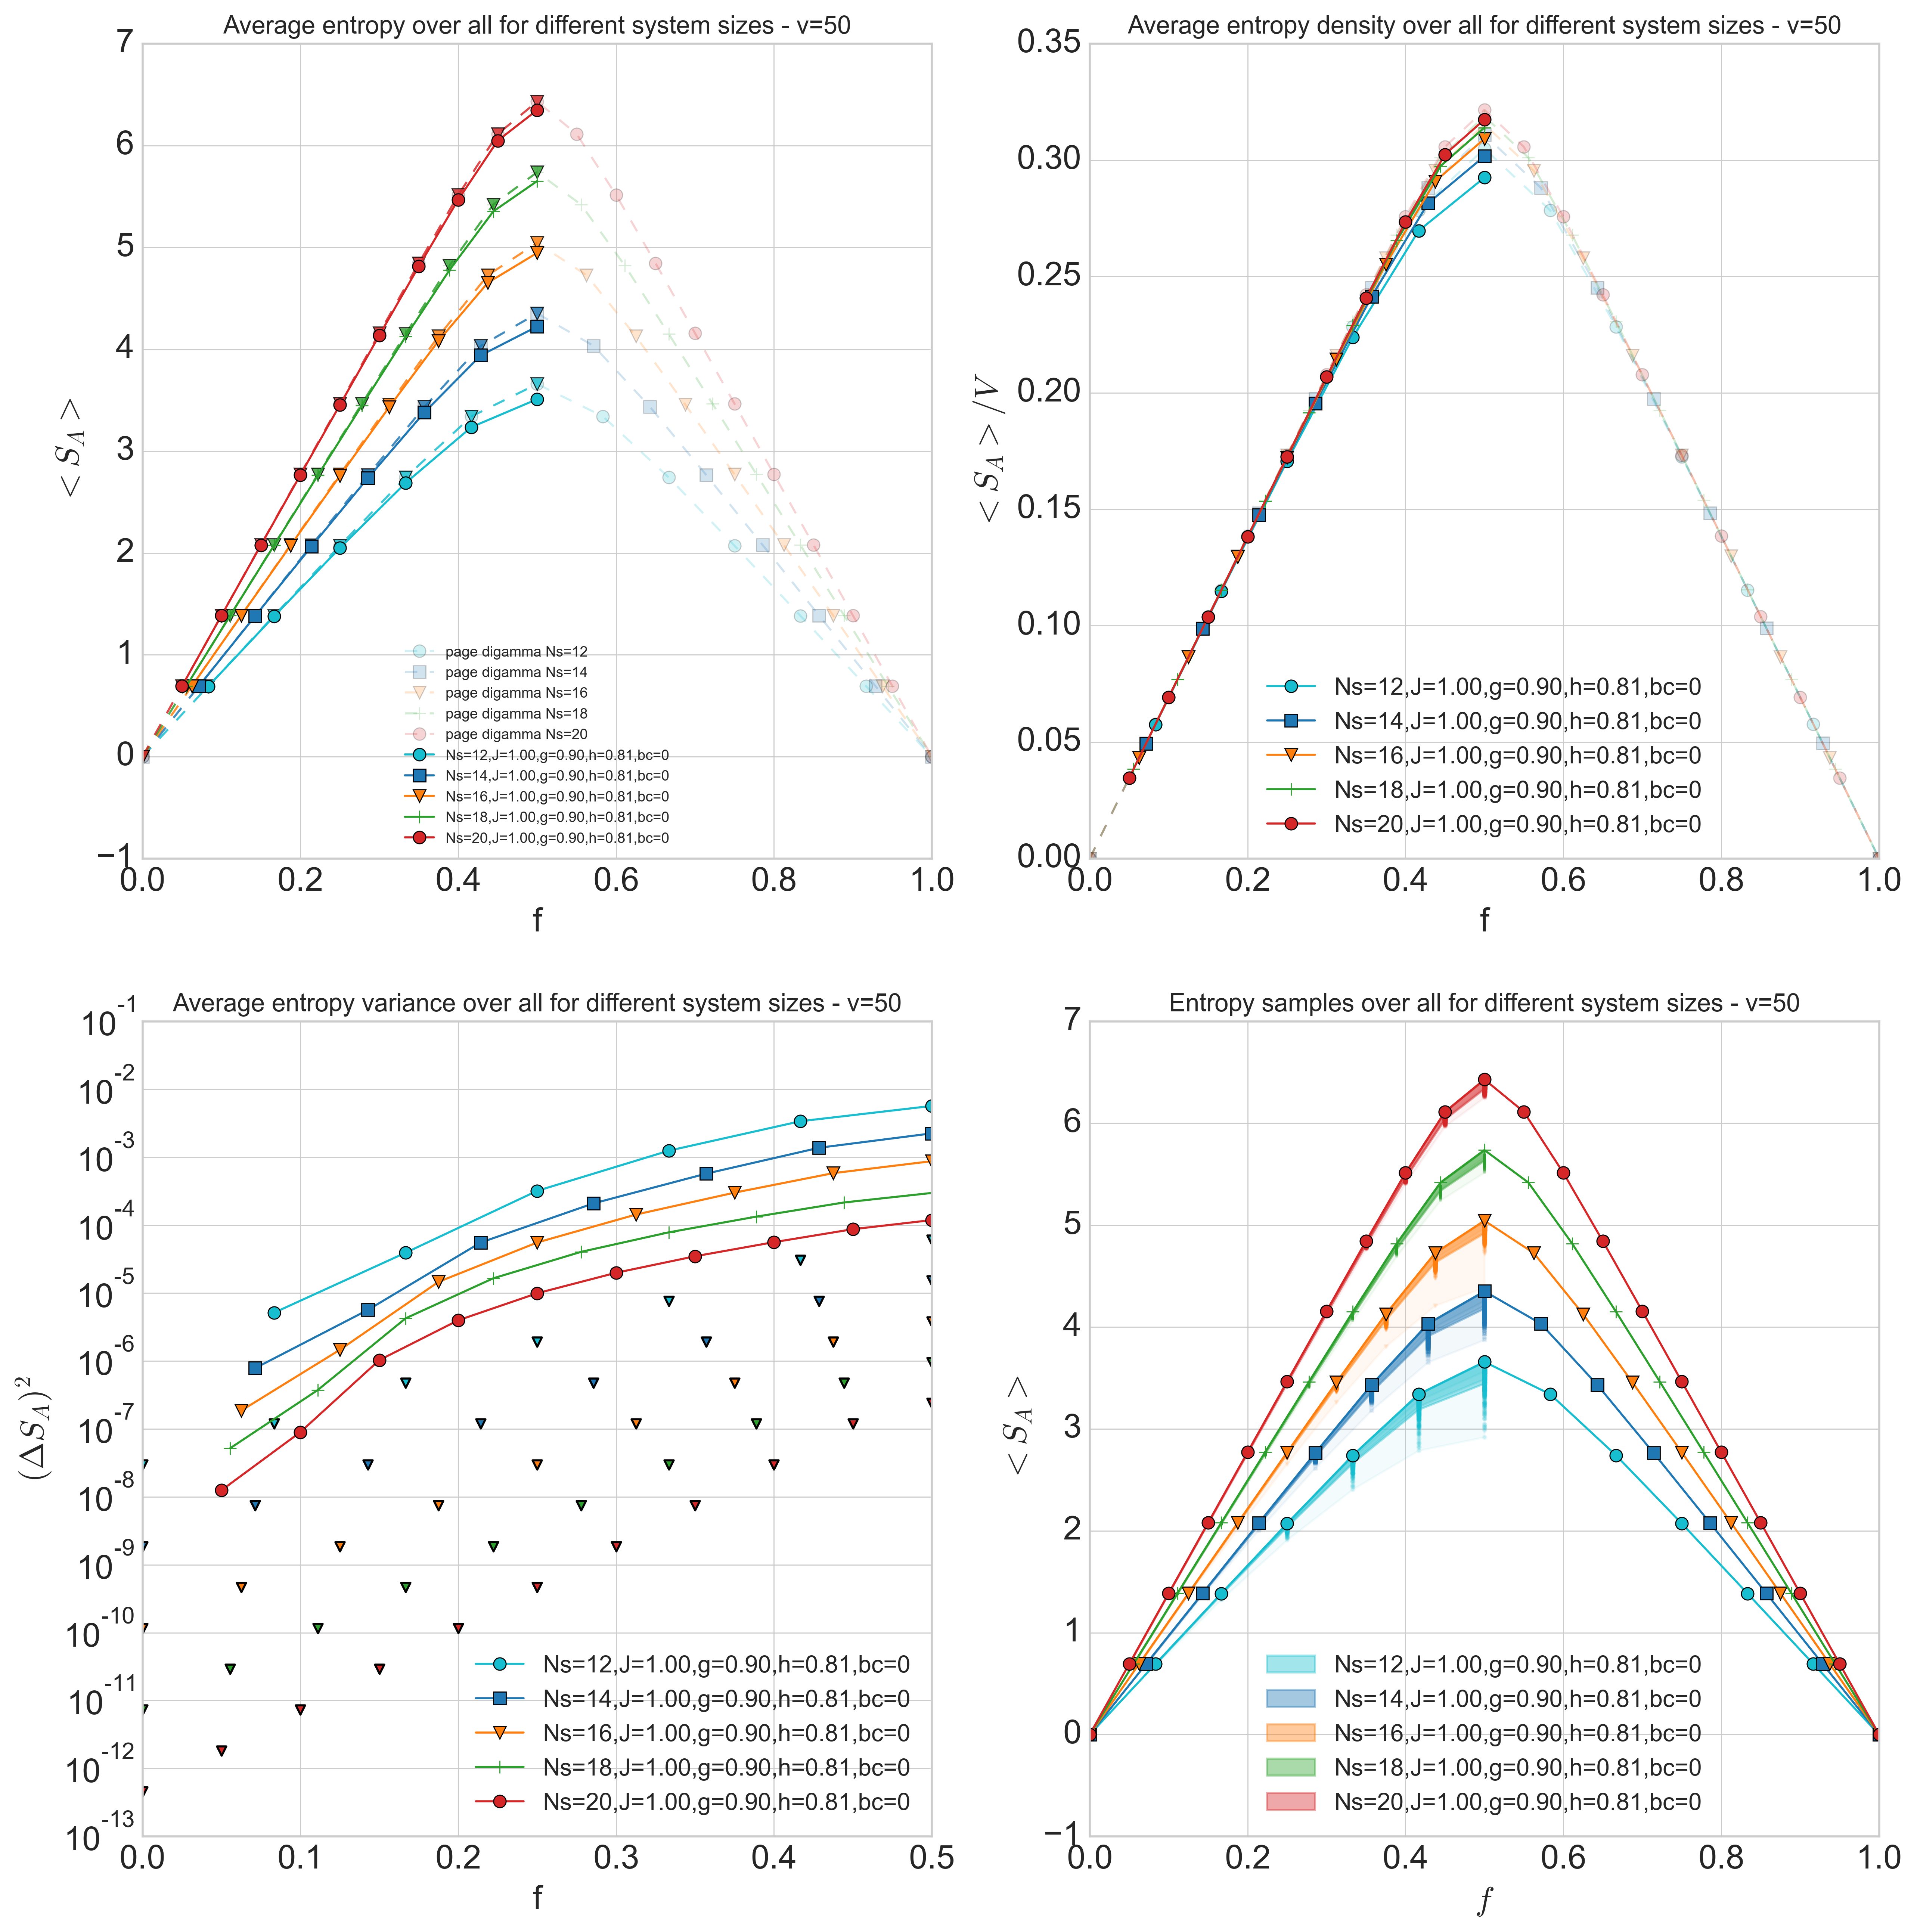

In [94]:
Ls=[12, 14, 16, 18, 20]
sector = 'all'
plot_model_avs(Ls, model, fraction, directory_save, sector)


### CLOUD

----------------------> STARTING PBC <----------------------


-->For 12,sym=(0, 1),frac=100,bc=0 reading the av_S file
-->For 12,sym=(1, 1),frac=100,bc=0 reading the av_S file
-->For 12,sym=(2, 1),frac=100,bc=0 reading the av_S file
-->For 12,sym=(3, 1),frac=100,bc=0 reading the av_S file
-->For 12,sym=(4, 1),frac=100,bc=0 reading the av_S file
-->For 12,sym=(5, 1),frac=100,bc=0 reading the av_S file
-->For 12,sym=(6, 1),frac=100,bc=0 reading the av_S file
-->For 12,sym=(7, 1),frac=100,bc=0 reading the av_S file
-->For 12,sym=(8, 1),frac=100,bc=0 reading the av_S file
-->For 12,sym=(9, 1),frac=100,bc=0 reading the av_S file
-->For 12,sym=(10, 1),frac=100,bc=0 reading the av_S file
-->For 12,sym=(11, 1),frac=100,bc=0 reading the av_S file
-->For 12,sym=(0, -1),frac=100,bc=0 reading the av_S file
-->For 12,sym=(6, -1),frac=100,bc=0 reading the av_S file
	->Did capture whole Hilbert space - for Ns = 12, bc = 0, frac = 100
		->Total number of states = 1400 out of 4096 frac = 0.3418

-->Fo

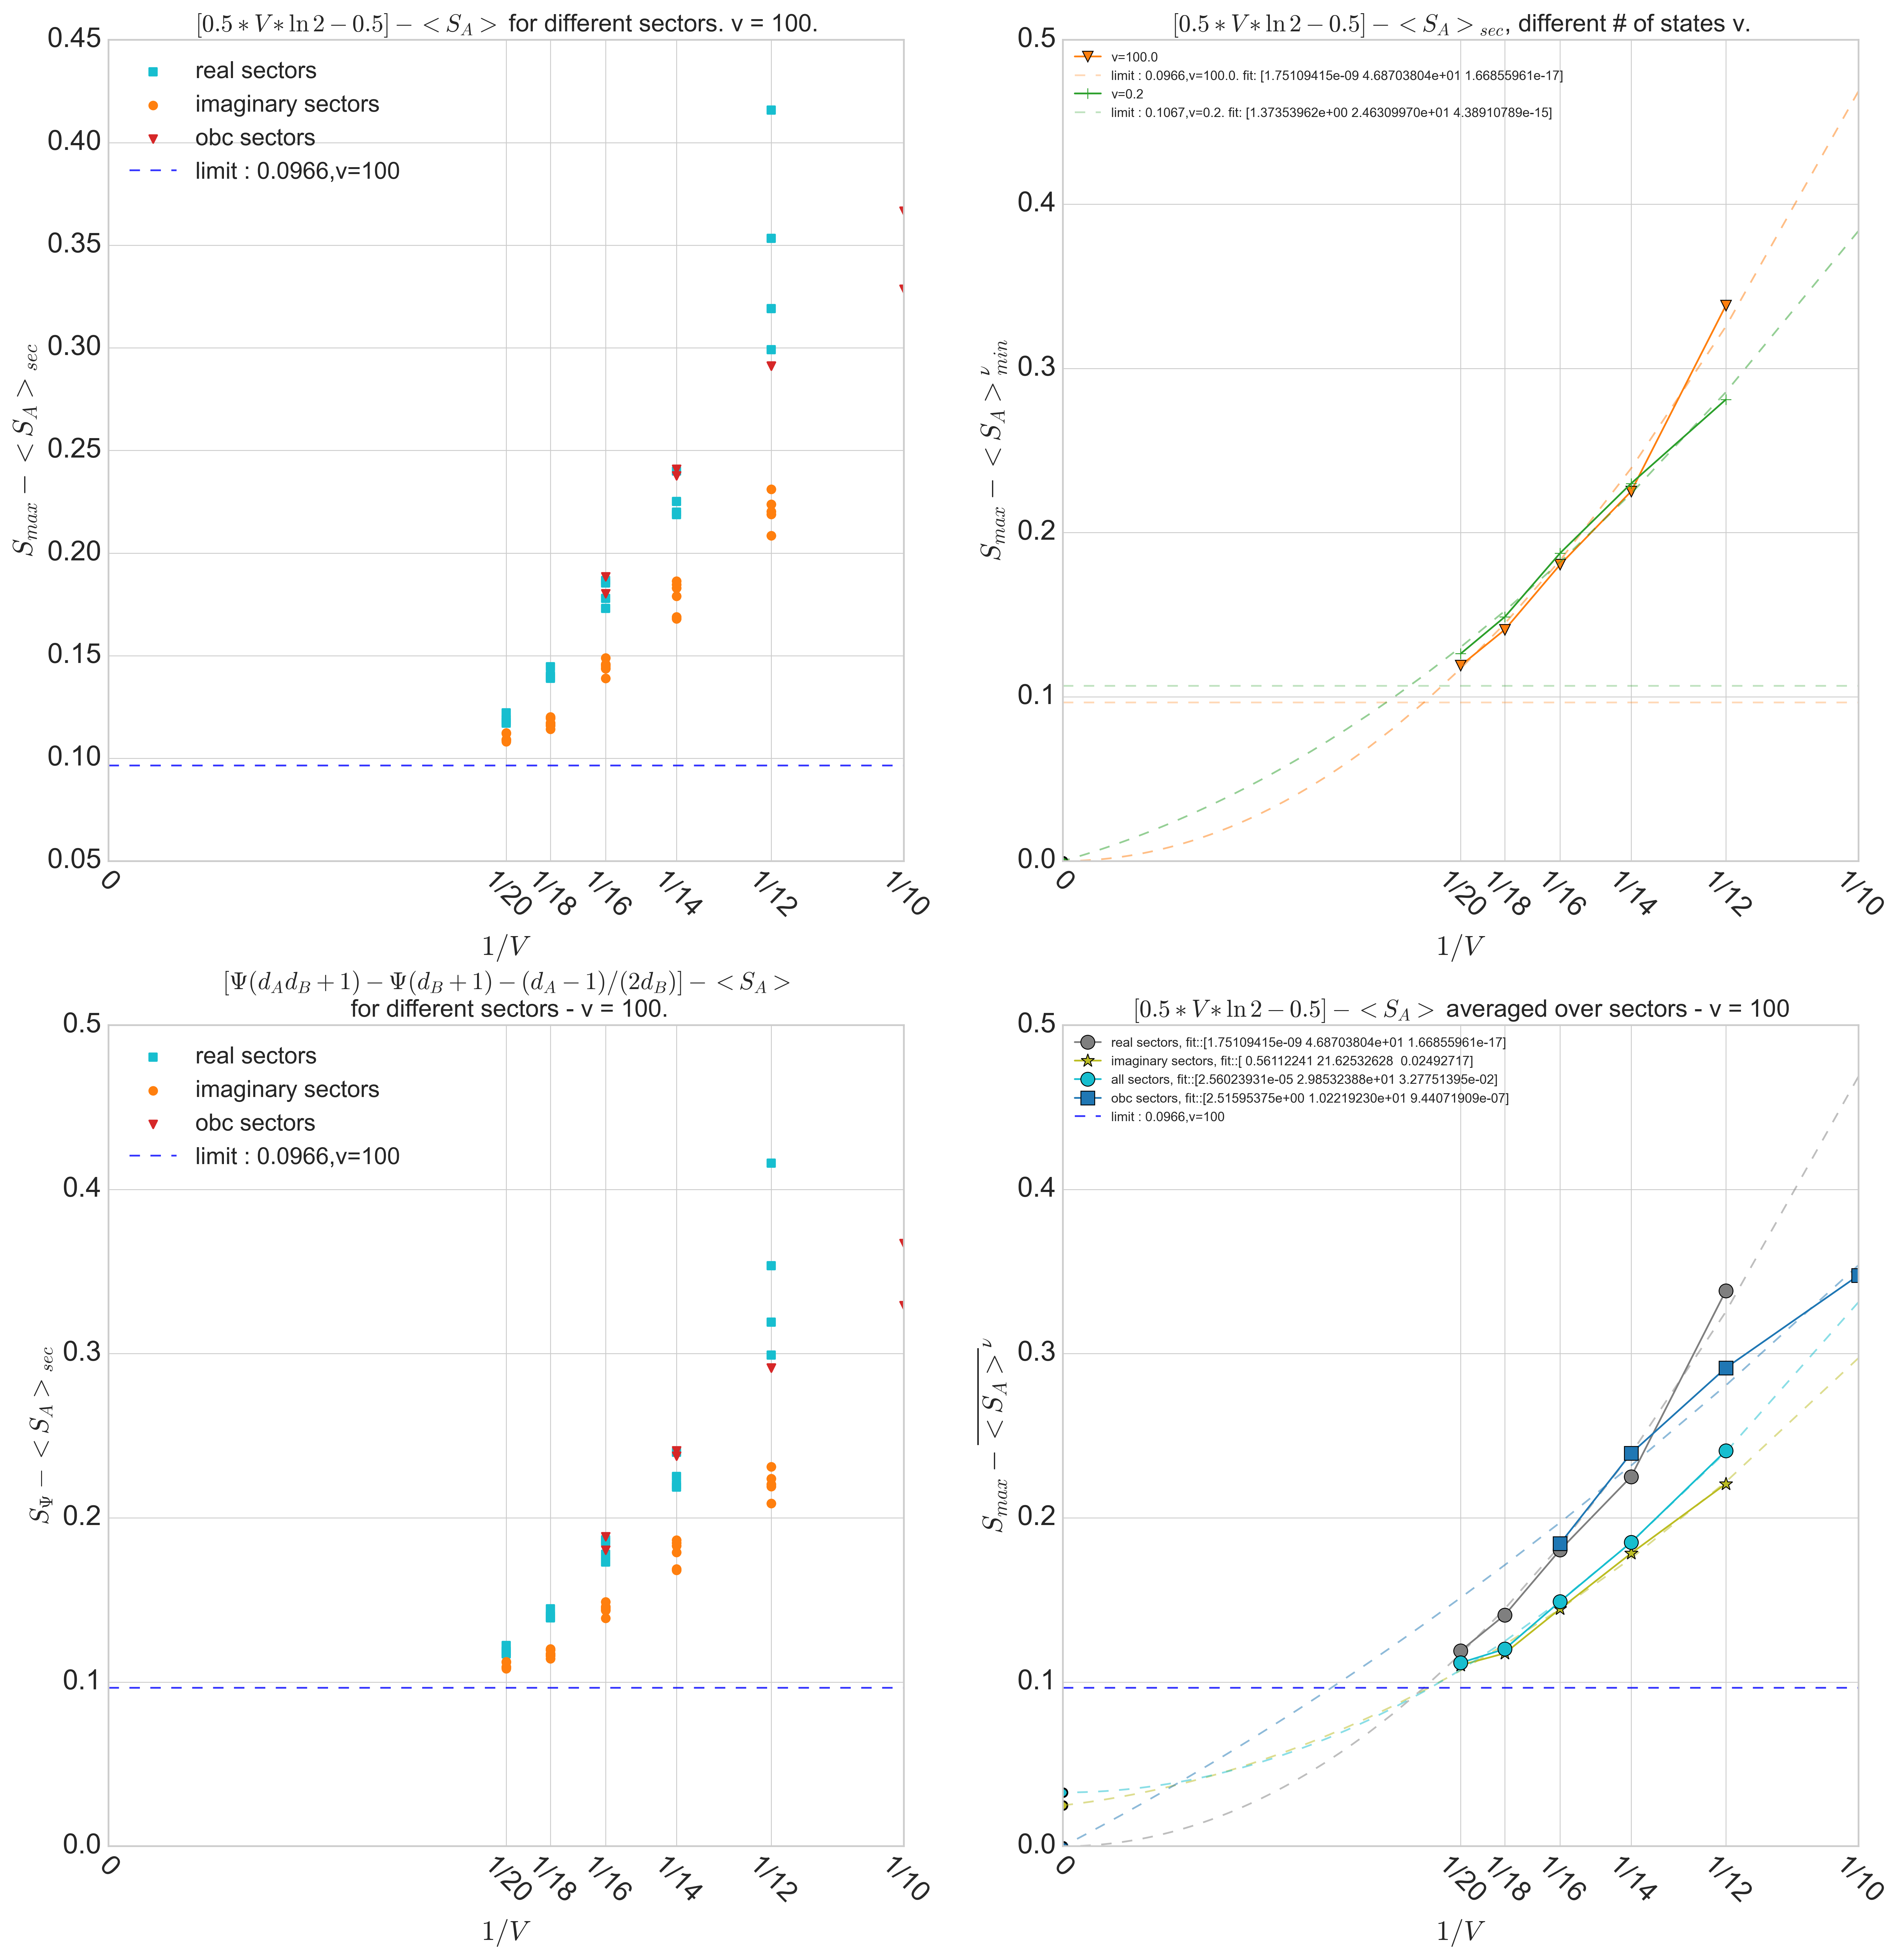

(                         12                     14                     16  \
 100.0  [0.3382537620088626]  [0.22509818421206784]   [0.1805015604321456]   
 0.2    [0.2810061098036667]  [0.22991592596246946]  [0.18749287739640597]   
 
                           18                     20  
 100.0    [0.140916939891504]  [0.11902687016124425]  
 0.2    [0.14867961052089917]    [0.126258826814432]  ,
 {'real': array([1.75109415e-09, 4.68703804e+01, 1.66855961e-17]),
  'img': array([ 0.56112241, 21.62532628,  0.02492717]),
  'all': array([2.56023931e-05, 2.98532388e+01, 3.27751395e-02]),
  'obc': array([2.51595375e+00, 1.02219230e+01, 9.44071909e-07])},
 {100.0: array([1.75109415e-09, 4.68703804e+01, 1.66855961e-17]),
  0.2: array([1.37353962e+00, 2.46309970e+01, 4.38910789e-15])})

In [15]:
Ls=[12, 14, 16, 18, 20]
fractions = [100, 0.2]
ylim = [0, 0.5]
avs = 'av_Sr'
#avs = 'av_So'
#avs = 'av_S'
#avs = 'av_Sobc'

fit_fun = fit_one_over_v2
#fit_fun = fit_one_over_v
direct = directory
direct = directory_save
dif_fun = digamma_difference
#dif_fun = page_difference

plot_difference_cloud(Ls, fractions, model, directory = direct, xscale='linear', yscale='linear',
                      ylim = ylim, fit_fun = fit_fun, avs=avs, dif_fun=dif_fun)

### VARIANCE

----------------------> STARTING PBC <----------------------


-->For 12,sym=(0, 1),frac=0.5,bc=0 reading the var file
-->For 12,sym=(1, 1),frac=0.5,bc=0 reading the var file
-->For 12,sym=(2, 1),frac=0.5,bc=0 reading the var file
-->For 12,sym=(3, 1),frac=0.5,bc=0 reading the var file
-->For 12,sym=(4, 1),frac=0.5,bc=0 reading the var file
-->For 12,sym=(5, 1),frac=0.5,bc=0 reading the var file
-->For 12,sym=(6, 1),frac=0.5,bc=0 reading the var file
-->For 12,sym=(7, 1),frac=0.5,bc=0 reading the var file
-->For 12,sym=(8, 1),frac=0.5,bc=0 reading the var file
-->For 12,sym=(9, 1),frac=0.5,bc=0 reading the var file
-->For 12,sym=(10, 1),frac=0.5,bc=0 reading the var file
-->For 12,sym=(11, 1),frac=0.5,bc=0 reading the var file
-->For 12,sym=(0, -1),frac=0.5,bc=0 reading the var file
-->For 12,sym=(6, -1),frac=0.5,bc=0 reading the var file
	->Did capture whole Hilbert space - for Ns = 12, bc = 0, frac = 0.5
		->Total number of states = 2050 out of 4096 frac = 0.5005

-->For 14,sym=(0, 1

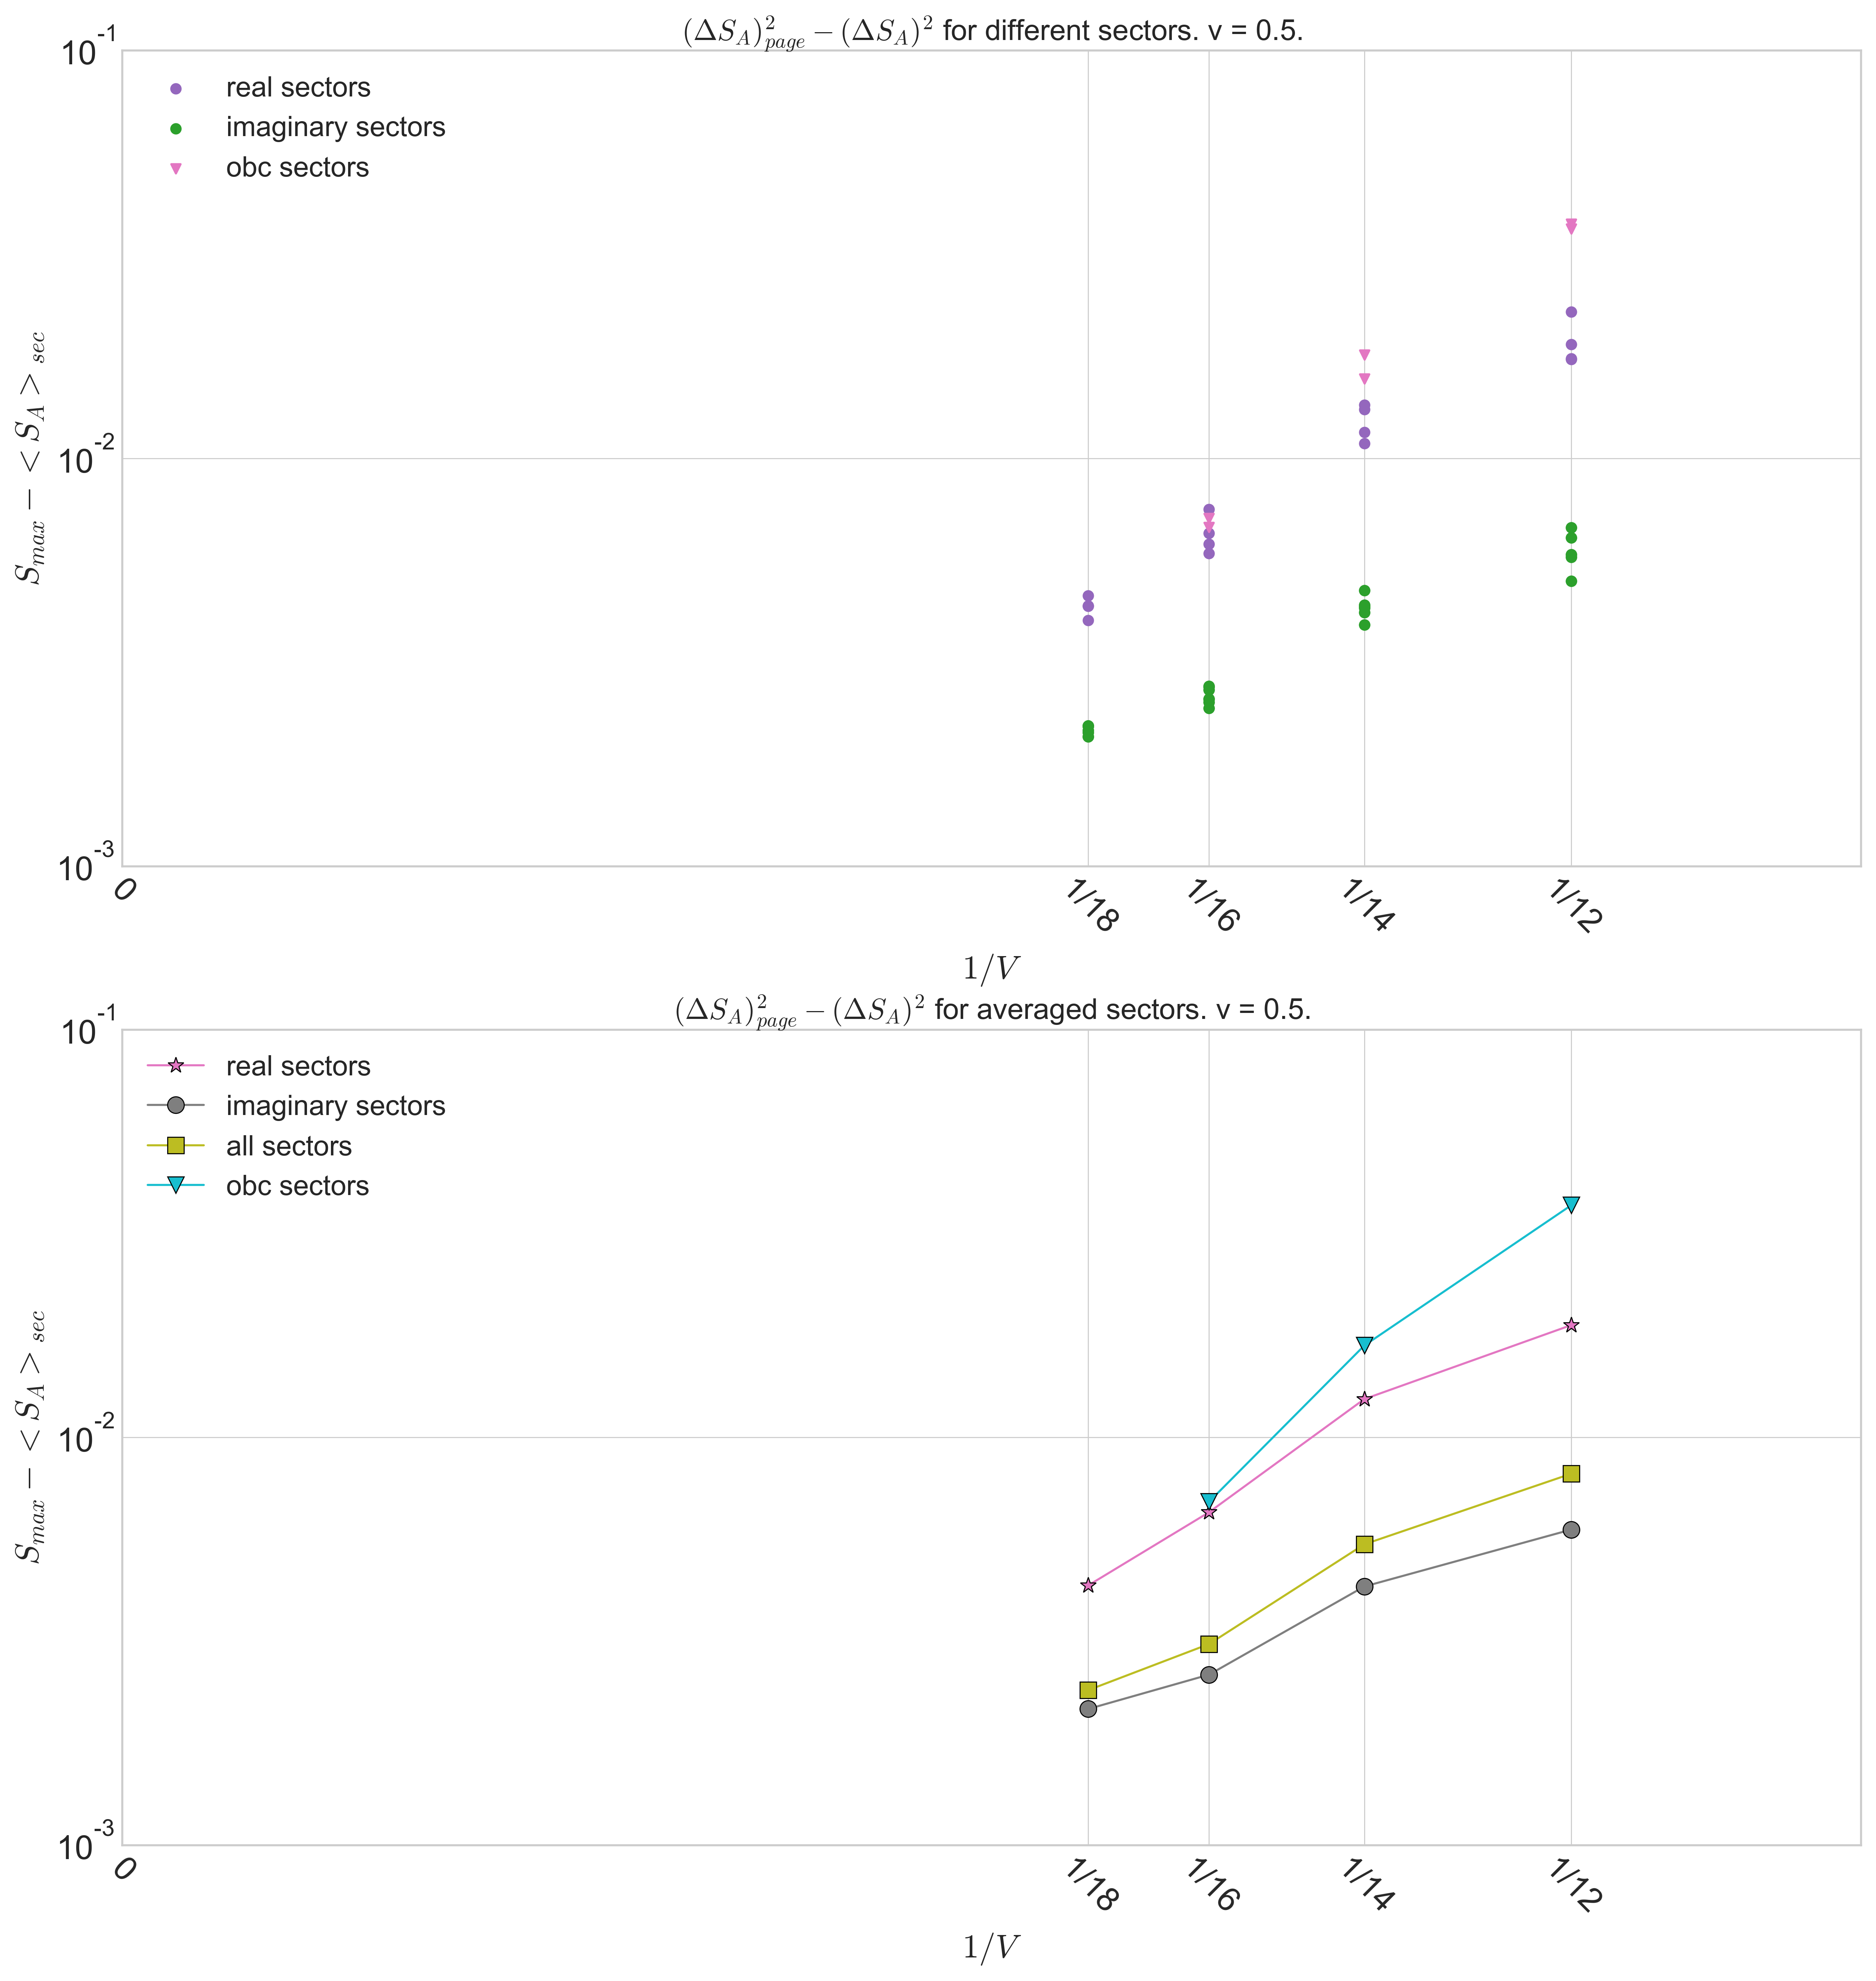

In [39]:
Ls=[12, 14, 16, 18]
fractions = [0.5]
dif_fun = digamma_difference_v

plot_variances(Ls, fractions, model, directory = directory_save, system_frac=0.5, dif_fun = dif_fun)

### CLOUD_LINEAR

----------------------> STARTING PBC <----------------------


-->For 12,sym=(0, 1),frac=0.25,bc=0 reading the av_S file
-->For 12,sym=(1, 1),frac=0.25,bc=0 reading the av_S file
-->For 12,sym=(2, 1),frac=0.25,bc=0 reading the av_S file
-->For 12,sym=(3, 1),frac=0.25,bc=0 reading the av_S file
-->For 12,sym=(4, 1),frac=0.25,bc=0 reading the av_S file
-->For 12,sym=(5, 1),frac=0.25,bc=0 reading the av_S file
-->For 12,sym=(6, 1),frac=0.25,bc=0 reading the av_S file
-->For 12,sym=(7, 1),frac=0.25,bc=0 reading the av_S file
-->For 12,sym=(8, 1),frac=0.25,bc=0 reading the av_S file
-->For 12,sym=(9, 1),frac=0.25,bc=0 reading the av_S file
-->For 12,sym=(10, 1),frac=0.25,bc=0 reading the av_S file
-->For 12,sym=(11, 1),frac=0.25,bc=0 reading the av_S file
-->For 12,sym=(0, -1),frac=0.25,bc=0 reading the av_S file
-->For 12,sym=(6, -1),frac=0.25,bc=0 reading the av_S file
	->Did capture whole Hilbert space - for Ns = 12, bc = 0, frac = 0.25
		->Total number of states = 1024 out of 4096 frac 

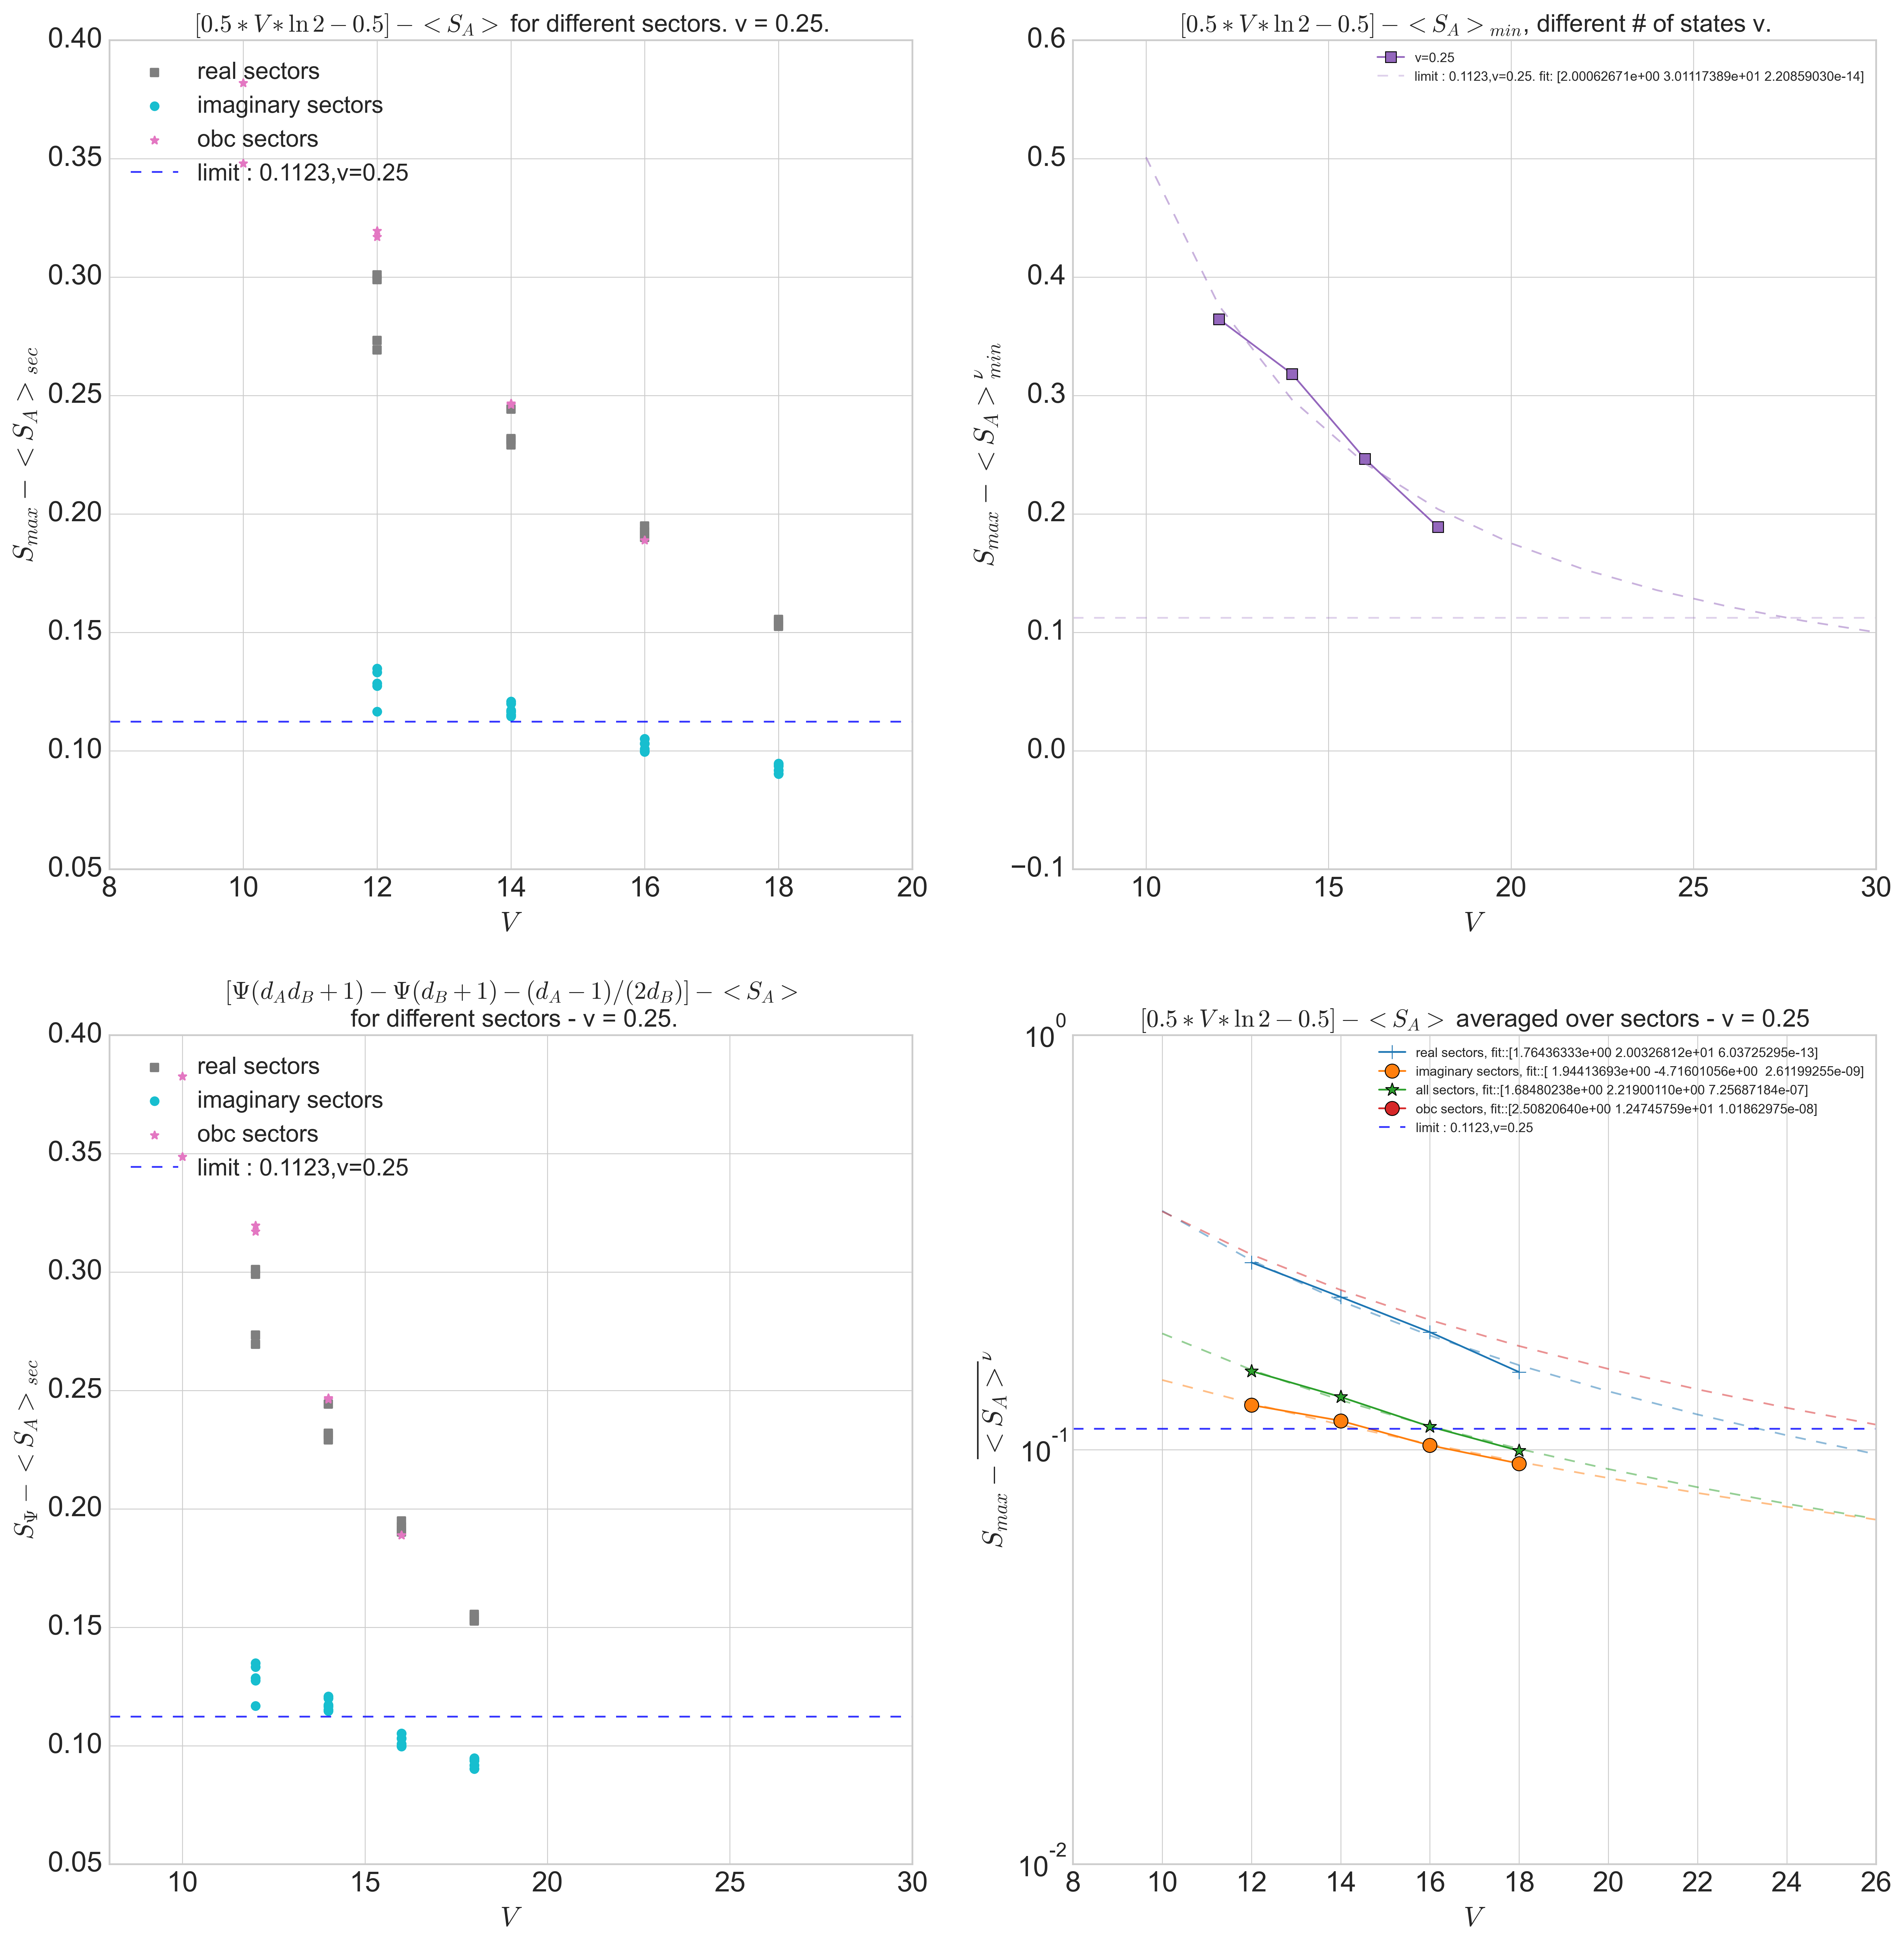

(                        10                     12                     14  \
 0.25  [0.3644808639054111]  [0.31826074197551346]  [0.24642463724435348]   
 
                          16  
 0.25  [0.18893733562244197]  ,
 {'real': array([1.76436333e+00, 2.00326812e+01, 6.03725295e-13]),
  'img': array([ 1.94413693e+00, -4.71601056e+00,  2.61199255e-09]),
  'all': array([1.68480238e+00, 2.21900110e+00, 7.25687184e-07]),
  'obc': array([2.50820640e+00, 1.24745759e+01, 1.01862975e-08])})

In [85]:
Ls=[12, 14, 16, 18]
fractions = [0.25]
ylim = [5e-2, 0.5]
xlim = [8, 30]
avs = 'av_Sobc'
fit_fun = fit_one_over_v2
#fit_fun = fit_one_over_v
direct = directory
direct = directory_save
dif_fun = digamma_difference
dif_fun = page_difference

plot_difference_cloud_linear(Ls, fractions, model, directory = direct, xscale='linear',
                      ylim = ylim, xlim = xlim, fit_fun = fit_fun, avs=avs, dif_fun=dif_fun)

### ALL

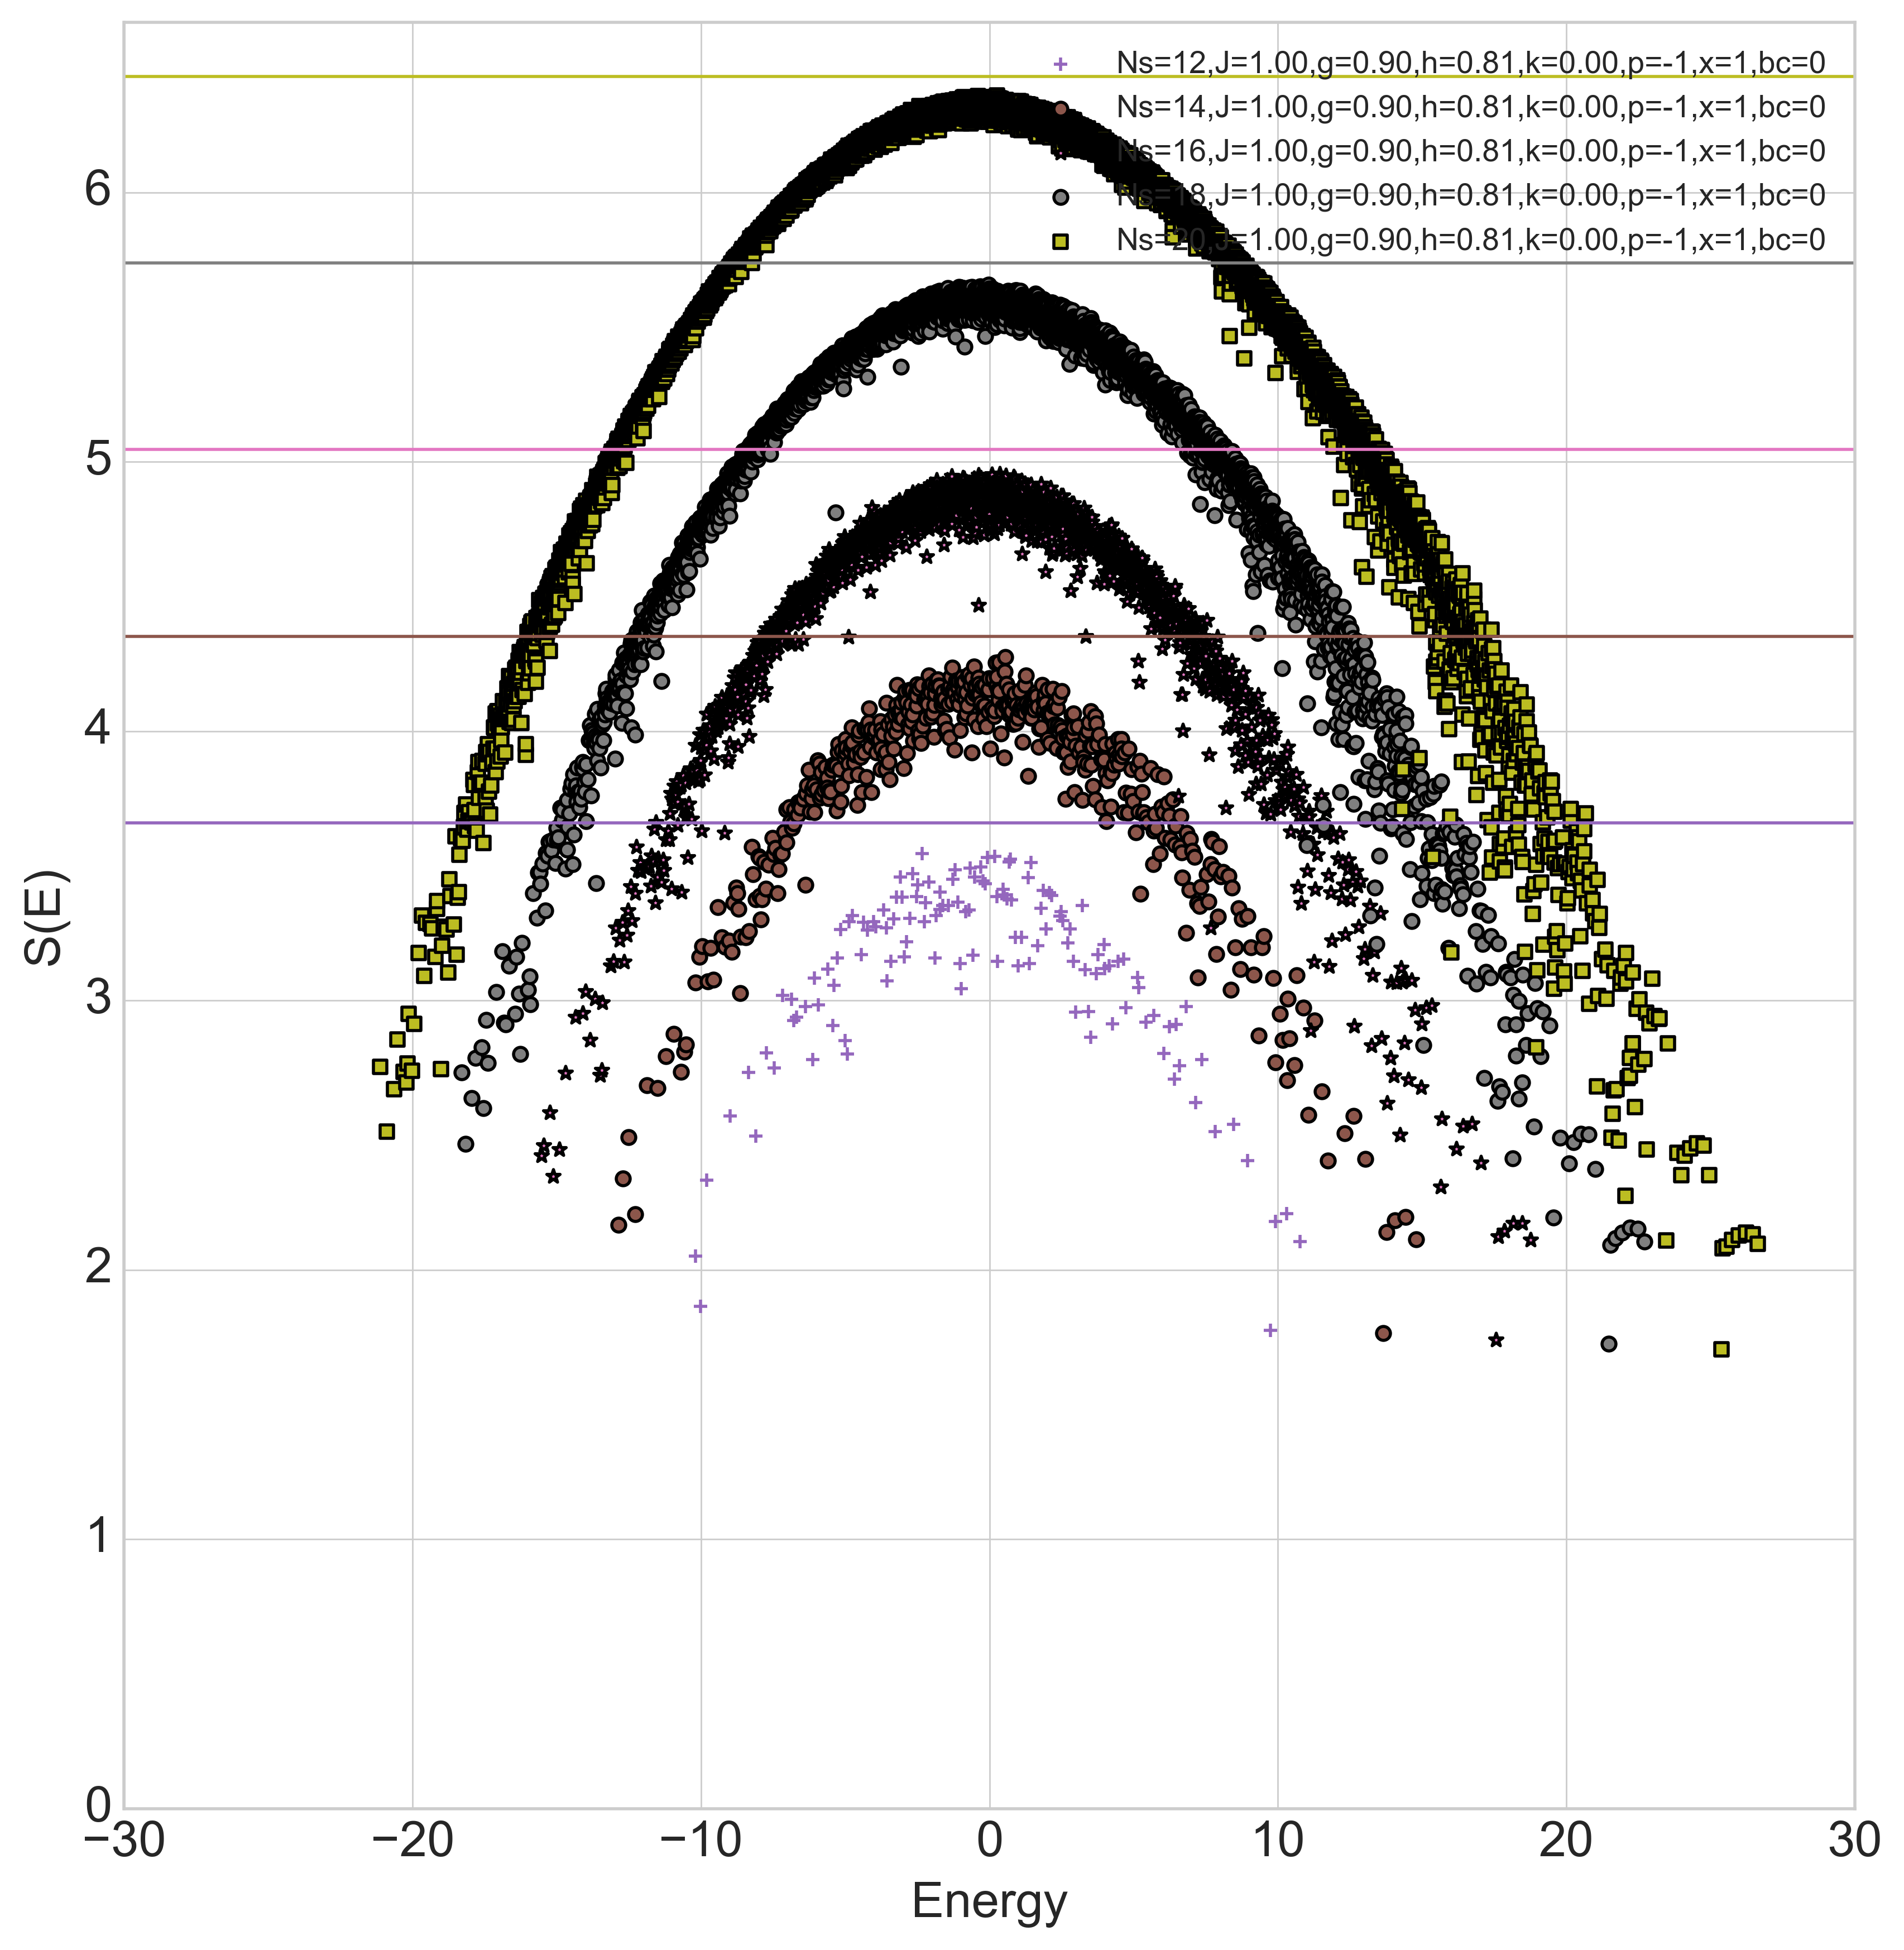

In [26]:
Ls=[12, 14, 16, 18, 20]
model.k = 0
model.p = -1
direct = directory
frac = 1.0
plot_all(Ls, model, frac, direct)

# TEST

In [164]:

import struct
L = 14
N = 687
size_x = (L//2)
values = np.zeros(size_x * N, dtype = np.float64)
FLOAT_SIZE = 8

filename = "res\\res2\\resultsSym14\\_ising_sym,Ns=14,J=1.00,g=0.90,h=0.81,k=0.00,p=1,x=1,bc=0\\entropies,spectrum_num=687.bin"
with open(filename, mode='rb') as file: # b is important -> binary
    #for idx in range(NUM_OFFSETS):
    idx = 0
    while file:
        binary = file.read(FLOAT_SIZE)
        if not binary:
            break

        val = struct.unpack("d", binary)[0]
        values[idx] = val
        idx+=1

        #values = np.frombuffer(file, np.dtype('float64'), offset=0)
#values = values.reshape(size_x, N)
    #for i in range(L//2+1):
    #    for j in range(N):
    #        idx = i * size_x + j
    #        val = struct.unpack("d", fileContent[8*(idx-1):8*idx])
    #        print(val)
    #        values[idx] = 1
values

    

array([0.451847  , 0.56745203, 0.62845866, ..., 0.00367648, 0.00367648,
       0.00367648])

In [26]:
file

<_io.BufferedReader name='C:/University/PHD/CODES/VQMC/VarQMCSolver/cpp/VQMC_S/resultsSym2/_ising_sym,Ns=12,J=1.00,g=0.90,h=0.81,k=0.00,p=1,x=1,bc=0/entropies,spectrum_num=224.bin'>